# Multi-Source Fundamentals Strategy

This notebook demonstrates:
1. **Multi-source data integration** - Combining Sharadar and custom LSEG fundamentals
2. **FlightLog monitoring** - Real-time log streaming
3. **Pyfolio analysis** - Comprehensive performance tearsheet
4. **run_strategy helper** - Easy strategy execution

## Strategy Overview

**Combined Quality Strategy:**
- Universe: Top 100 stocks by market cap (Sharadar)
- Quality filter: 
  - LSEG: ROE > 15%, PEG < 2.5
  - Sharadar: FCF > 0, PE < 30
- Selection: Top 5 by LSEG ROE with combined quality filter
- Rebalance: Weekly

**Note:** The current Sharadar bundle has an empty ROE field, so we use LSEG ROE for profitability and Sharadar for cash flow/valuation metrics.

## Prerequisites

1. **Sharadar bundle ingested:** `zipline ingest -b sharadar`
2. **Custom LSEG database:** `~/.zipline/data/custom/fundamentals.sqlite`
3. **FlightLog running:** Check terminal on port 9020 (optional)
4. **Pyfolio installed:** `pip install pyfolio-reloaded`

## Setup: Register Bundle and Import Multi-Source Module

In [1]:
# Register Sharadar bundle (required for Jupyter notebooks)
from zipline.data.bundles import register
from zipline.data.bundles.sharadar_bundle import sharadar_bundle

register(
    'sharadar',
    sharadar_bundle(
        tickers=None,
        incremental=True,
        include_funds=True,
    ),
)

print("✓ Sharadar bundle registered")

✓ Sharadar bundle registered


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import warnings
warnings.filterwarnings('ignore')

# Import the centralized multi-source module - simple!
from zipline.pipeline import multi_source as ms

# Zipline API
from zipline import run_algorithm
from zipline.api import (
    attach_pipeline,
    pipeline_output,
    order_target_percent,
    schedule_function,
    date_rules,
    time_rules,
    record,
)

# Progress logging
from zipline.utils.progress import enable_progress_logging

# Setup logging
logging.basicConfig(level=logging.INFO, force=True)
logging.getLogger('matplotlib.category').setLevel(logging.WARNING)

print("✓ Imports successful")
print(f"\nAvailable multi_source components:")
print(f"  - ms.Pipeline")
print(f"  - ms.Database")
print(f"  - ms.Column")
print(f"  - ms.sharadar")
print(f"  - ms.setup_auto_loader()")

✓ Imports successful

Available multi_source components:
  - ms.Pipeline
  - ms.Database
  - ms.Column
  - ms.sharadar
  - ms.setup_auto_loader()


## Setup FlightLog (Optional)

FlightLog provides real-time log monitoring in a separate terminal with color-coded output.

### What is FlightLog?

FlightLog is a centralized logging server that:
- Displays logs in real-time with color coding (INFO=green, WARNING=yellow, ERROR=red)
- Shows timestamps and log levels
- Streams output from multiple sources simultaneously
- Helps debug issues during backtest execution

### How to Start FlightLog

**Option 1: Using Docker (Recommended)**

1. **Check if FlightLog container is running:**
   ```bash
   docker ps | grep flightlog
   ```

2. **If not running, start it:**
   ```bash
   docker compose up -d flightlog
   ```

3. **Open a second terminal and stream logs:**
   ```bash
   docker logs -f zipline-flightlog
   ```
   
   This will show colorized, real-time logs as the backtest runs.

**Option 2: Manual Start (Non-Docker)**

1. **In a separate terminal, start FlightLog server:**
   ```bash
   python -m zipline.utils.flightlog_server --port 9020
   ```

2. **Keep this terminal open** to see logs streaming in real-time

### Troubleshooting

If FlightLog connection fails:
- **Check container status:** `docker ps | grep flightlog`
- **Check logs:** `docker logs zipline-flightlog`
- **Restart container:** `docker compose restart flightlog`
- **Verify port:** FlightLog uses port 9020 by default

Don't worry if FlightLog isn't available - the notebook will continue without it!


In [3]:
from zipline.utils.flightlog_client import enable_flightlog, log_to_flightlog

# Enable FlightLog
try:
    enable_flightlog(host='localhost', port=9020)
    log_to_flightlog('🚀 Multi-Source Strategy - FlightLog Connected', level='INFO')
    print("✅ FlightLog enabled - check your second terminal!")
    FLIGHTLOG_ENABLED = True
except Exception as e:
    print(f"⚠️  FlightLog not available: {e}")
    print("   Continuing without FlightLog...")
    FLIGHTLOG_ENABLED = False
    # Define no-op function
    def log_to_flightlog(msg, level='INFO'):
        pass

INFO:algorithm:🚀 Multi-Source Strategy - FlightLog Connected


✅ FlightLog enabled - check your second terminal!


In [4]:
# Enable progress logging
enable_progress_logging(
    algo_name='MultiSource-Consensus',
    update_interval=5  # Update every 5 trading days
)

print("✅ Progress logging enabled")

✅ Progress logging enabled


## Define Custom LSEG Fundamentals Database

Using the new centralized imports, defining a custom database is simple:

In [5]:
class LSEGFundamentals(ms.Database):
    """Custom LSEG fundamentals database."""
    
    CODE = "fundamentals"  # Must match SQLite database name
    LOOKBACK_WINDOW = 252
    
    # Define columns matching database schema
    ReturnOnEquity_SmartEstimat = ms.Column(float)
    ForwardPEG_DailyTimeSeriesRatio_ = ms.Column(float)
    CompanyMarketCap = ms.Column(float)
    Debt_Total = ms.Column(float)

print("✓ LSEG Fundamentals database defined")
print(f"  Database: {LSEGFundamentals.CODE}")
print(f"  Location: ~/.zipline/data/custom/{LSEGFundamentals.CODE}.sqlite")
print(f"  Columns: {', '.join([k for k in dir(LSEGFundamentals) if not k.startswith('_') and k not in ['CODE', 'LOOKBACK_WINDOW']])}")

✓ LSEG Fundamentals database defined
  Database: fundamentals
  Location: ~/.zipline/data/custom/fundamentals.sqlite
  Columns: CompanyMarketCap, Debt_Total, ForwardPEG_DailyTimeSeriesRatio_, ReturnOnEquity_SmartEstimat


## Create Multi-Source Pipeline

Mix Sharadar and LSEG data seamlessly in one pipeline:

In [6]:
def make_pipeline(universe_size=100, selection_size=5):
    """
    Multi-source consensus quality pipeline.
    
    Combines Sharadar and LSEG fundamentals to find high-quality stocks.
    
    NOTE: Sharadar ROE field is empty in the current bundle, so we use:
    - LSEG ROE for quality filtering
    - Sharadar FCF, PE, MarketCap for other metrics
    """
    # ========================================================================
    # Sharadar Fundamentals (ROE not available, using FCF/PE instead)
    # ========================================================================
    s_fcf = ms.SharadarFundamentals.fcf.latest
    s_marketcap = ms.SharadarFundamentals.marketcap.latest
    s_pe = ms.SharadarFundamentals.pe.latest
    
    # ========================================================================
    # LSEG Custom Fundamentals
    # ========================================================================
    l_roe = LSEGFundamentals.ReturnOnEquity_SmartEstimat.latest
    l_peg = LSEGFundamentals.ForwardPEG_DailyTimeSeriesRatio_.latest
    l_marketcap = LSEGFundamentals.CompanyMarketCap.latest
    l_debt = LSEGFundamentals.Debt_Total.latest
    
    # ========================================================================
    # Universe: Top N by market cap (Sharadar)
    # ========================================================================
    universe = s_marketcap.top(universe_size)
    
    # ========================================================================
    # Quality Filters
    # ========================================================================
    # Sharadar quality (using FCF and PE, no ROE available)
    sharadar_quality = (
        (s_fcf > 0) &
        (s_pe > 0) & (s_pe < 30)
    )
    
    # LSEG quality (using ROE and PEG)
    lseg_quality = (
        (l_roe > 15.0) &
        (l_peg > 0) & (l_peg < 2.5)
    )
    
    # ========================================================================
    # Combined Filter: Quality from both sources
    # ========================================================================
    combined_quality = sharadar_quality & lseg_quality
    
    # ========================================================================
    # Selection: Top M by LSEG ROE with combined quality filter
    # ========================================================================
    selection = l_roe.top(selection_size, mask=universe & combined_quality)
    
    return ms.Pipeline(
        columns={
            # Sharadar metrics (no ROE)
            's_fcf': s_fcf,
            's_marketcap': s_marketcap,
            's_pe': s_pe,
            # LSEG metrics
            'l_roe': l_roe,
            'l_peg': l_peg,
            'l_marketcap': l_marketcap,
            'l_debt': l_debt,
            # Quality flags
            'sharadar_quality': sharadar_quality,
            'lseg_quality': lseg_quality,
            'combined_quality': combined_quality,
        },
        screen=selection,
    )

print("✓ Multi-source pipeline defined")
print("\nPipeline features:")
print("  - Sharadar: FCF, MarketCap, PE")
print("  - LSEG: ROE, PEG, MarketCap, Debt")
print("  - Combined quality: Sharadar metrics + LSEG ROE/PEG")
print("  - Universe: Top 100 by market cap")
print("  - Selection: Top 5 by LSEG ROE with quality filter")

✓ Multi-source pipeline defined

Pipeline features:
  - Sharadar: FCF, MarketCap, PE
  - LSEG: ROE, PEG, MarketCap, Debt
  - Combined quality: Sharadar metrics + LSEG ROE/PEG
  - Universe: Top 100 by market cap
  - Selection: Top 5 by LSEG ROE with quality filter


## Define Strategy Functions

In [7]:
def initialize(context):
    """Initialize strategy."""
    log_to_flightlog('='*80, level='INFO')
    log_to_flightlog('🚀 Multi-Source Consensus Quality Strategy', level='INFO')
    log_to_flightlog('='*80, level='INFO')
    
    # Attach pipeline
    pipe = make_pipeline(universe_size=100, selection_size=5)
    attach_pipeline(pipe, 'multi_source')
    
    log_to_flightlog('Pipeline attached:', level='INFO')
    log_to_flightlog('  - Data sources: Sharadar + LSEG', level='INFO')
    log_to_flightlog('  - Universe: Top 100 by market cap', level='INFO')
    log_to_flightlog('  - Selection: Top 5 by LSEG ROE (quality filter)', level='INFO')
    
    # Schedule weekly rebalancing
    schedule_function(
        rebalance,
        date_rules.week_start(),
        time_rules.market_open(hours=1)
    )
    
    log_to_flightlog('  - Rebalancing: Weekly (Monday at market open)', level='INFO')
    log_to_flightlog('='*80, level='INFO')
    
    # Initialize tracking
    context.rebalance_count = 0
    context.confirmed_selections = []


def before_trading_start(context, data):
    """Get pipeline data before market opens."""
    context.pipeline_data = pipeline_output('multi_source')


def rebalance(context, data):
    """Weekly rebalancing."""
    context.rebalance_count += 1
    
    if context.pipeline_data is None or context.pipeline_data.empty:
        log_to_flightlog(f'⚠️  Rebalance #{context.rebalance_count}: No stocks in pipeline', level='WARNING')
        return
    
    # Get tradeable stocks
    all_selected = context.pipeline_data.index
    selected_stocks = [s for s in all_selected if data.can_trade(s)]
    
    if not selected_stocks:
        log_to_flightlog(f'⚠️  Rebalance #{context.rebalance_count}: No tradeable stocks', level='WARNING')
        return
    
    # Equal weight
    target_weight = 1.0 / len(selected_stocks)
    
    # Get current positions
    current_positions = set(context.portfolio.positions.keys())
    target_positions = set(selected_stocks)
    
    # Sell positions no longer selected
    for stock in current_positions - target_positions:
        if data.can_trade(stock):
            order_target_percent(stock, 0.0)
    
    # Buy/rebalance selected stocks
    for stock in selected_stocks:
        if data.can_trade(stock):
            order_target_percent(stock, target_weight)
    
    # Count quality confirmations
    combined_quality_count = context.pipeline_data['combined_quality'].sum()
    
    # Get stock symbols and key metrics
    holdings_info = []
    for stock in selected_stocks:
        symbol = stock.symbol
        l_roe = context.pipeline_data.loc[stock, 'l_roe']
        s_fcf = context.pipeline_data.loc[stock, 's_fcf']
        s_pe = context.pipeline_data.loc[stock, 's_pe']
        quality_flag = '✓' if context.pipeline_data.loc[stock, 'combined_quality'] else '✗'
        holdings_info.append(f"{symbol} (ROE:{l_roe:.1f}%, FCF:{s_fcf/1e6:.0f}M, PE:{s_pe:.1f} {quality_flag})")
    
    log_to_flightlog(
        f'📊 Rebalance #{context.rebalance_count}: '
        f'{len(selected_stocks)} stocks, {combined_quality_count} with quality confirmation',
        level='INFO'
    )
    log_to_flightlog(f'   Holdings: {", ".join(holdings_info)}', level='INFO')
    
    # Track for analysis
    context.confirmed_selections.append((data.current_dt, combined_quality_count, len(selected_stocks)))


def handle_data(context, data):
    """Record daily metrics."""
    record(
        portfolio_value=context.portfolio.portfolio_value,
        cash=context.portfolio.cash,
        leverage=context.account.leverage,
        positions_count=len(context.portfolio.positions),
    )


def analyze(context, perf):
    """Analyze results at end of backtest."""
    log_to_flightlog('='*80, level='INFO')
    log_to_flightlog('✅ Backtest Complete!', level='INFO')
    log_to_flightlog('='*80, level='INFO')
    
    # Calculate key metrics
    returns = perf['returns']
    final_value = perf['portfolio_value'].iloc[-1]
    initial_value = perf['portfolio_value'].iloc[0]
    total_return = (final_value / initial_value - 1) * 100
    
    # Sharpe ratio (annualized)
    sharpe = returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0
    
    # Max drawdown
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.expanding().max()
    drawdown = (cum_returns - running_max) / running_max
    max_dd = drawdown.min() * 100
    
    # Win rate
    winning_days = (returns > 0).sum()
    total_days = len(returns[returns != 0])
    win_rate = (winning_days / total_days * 100) if total_days > 0 else 0
    
    log_to_flightlog('BACKTEST SUMMARY:', level='INFO')
    log_to_flightlog(f'  Period: {perf.index[0].date()} to {perf.index[-1].date()}', level='INFO')
    log_to_flightlog(f'  Trading Days: {len(perf)}', level='INFO')
    log_to_flightlog(f'  Rebalances: {context.rebalance_count}', level='INFO')
    log_to_flightlog('', level='INFO')
    log_to_flightlog('PERFORMANCE:', level='INFO')
    log_to_flightlog(f'  Initial Value: ${initial_value:,.2f}', level='INFO')
    log_to_flightlog(f'  Final Value: ${final_value:,.2f}', level='INFO')
    log_to_flightlog(f'  Total Return: {total_return:.2f}%', level='INFO')
    log_to_flightlog(f'  Sharpe Ratio: {sharpe:.2f}', level='INFO')
    log_to_flightlog(f'  Max Drawdown: {max_dd:.2f}%', level='INFO')
    log_to_flightlog(f'  Win Rate: {win_rate:.1f}%', level='INFO')
    log_to_flightlog('='*80, level='INFO')
    
    return perf

print("✓ Strategy functions defined")

✓ Strategy functions defined


## Run Backtest with Auto Loader

Notice how simple this is - just one line for the loader setup!

In [8]:
# Backtest parameters
START = pd.Timestamp('2023-01-01')
END = pd.Timestamp('2024-11-01')
CAPITAL = 100000

print(f"Running backtest from {START.date()} to {END.date()}...")
print(f"Starting capital: ${CAPITAL:,.2f}")
print(f"Bundle: sharadar")
print(f"Custom DB: fundamentals")
print()

# Run backtest - notice the simple one-line loader setup!
results = run_algorithm(
    start=START,
    end=END,
    initialize=initialize,
    before_trading_start=before_trading_start,
    handle_data=handle_data,
    analyze=analyze,
    capital_base=CAPITAL,
    bundle='sharadar',
    custom_loader=ms.setup_auto_loader(),  # That's it! Auto-detects everything
)

print("\n✅ Backtest complete!")
print(f"Final portfolio value: ${results['portfolio_value'].iloc[-1]:,.2f}")

INFO:zipline.pipeline.loaders.auto_loader:AutoLoader initialized
INFO:zipline.pipeline.loaders.auto_loader:  Bundle: sharadar
INFO:zipline.pipeline.loaders.auto_loader:  Custom DB directory: /root/.zipline/data/custom
INFO:zipline.pipeline.loaders.auto_loader:  SID translation: enabled


Running backtest from 2023-01-01 to 2024-11-01...
Starting capital: $100,000.00
Bundle: sharadar
Custom DB: fundamentals

⚠ Yahoo Finance bundles not available: No module named 'zipline.data.bundles.yahoo_bundle'
⚠ NASDAQ Data Link bundles not available: No module named 'zipline.data.bundles.nasdaq_bundle'
✓ Sharadar bundles registered

Available bundles:
  - yahoo, yahoo-tech, yahoo-dow, yahoo-sp500
  - nasdaq, nasdaq-premium, nasdaq-free, nasdaq-sp500
  - sharadar, sharadar-tech, sharadar-sp500, sharadar-all

Use 'zipline bundles' to see which bundles have been ingested.
2025-11-18 07:41:55,868 INFO zipline.progress: [MultiSource-Consensus] Backtest initialized: 2023-01-03 to 2024-11-01 (462 trading days)
2025-11-18 07:41:55,868 INFO zipline.progress: [MultiSource-Consensus] Progress      Pct    Date             Cum Returns        Sharpe      Max DD             Cum PNL


INFO:algorithm:================================================================================
INFO:algorithm:🚀 Multi-Source Consensus Quality Strategy
INFO:algorithm:================================================================================
INFO:algorithm:Pipeline attached:
INFO:algorithm:  - Data sources: Sharadar + LSEG
INFO:algorithm:  - Universe: Top 100 by market cap
INFO:algorithm:  - Selection: Top 5 by LSEG ROE (quality filter)
INFO:algorithm:  - Rebalancing: Weekly (Monday at market open)
INFO:algorithm:================================================================================
INFO:algorithm:📊 Rebalance #1: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:73.9%, FCF:4461M, PE:20.7 ✓), ADBE (ROE:48.0%, FCF:1579M, PE:27.2 ✓), TJX (ROE:60.8%, FCF:647M, PE:27.2 ✓), UNP (ROE:60.0%, FCF:1858M, PE:16.2 ✓), CAT (ROE:48.5%, FCF:2062M, PE:15.1 ✓)
INFO:algorithm:📊 Rebalance #2: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO

2025-11-18 07:42:19,008 INFO zipline.progress: [MultiSource-Consensus] ----------      1%  2023-01-09              2%          2.84         -1%               $1.7K


INFO:algorithm:📊 Rebalance #3: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:73.9%, FCF:4461M, PE:20.7 ✓), QCOM (ROE:47.3%, FCF:812M, PE:9.7 ✓), TJX (ROE:60.8%, FCF:647M, PE:27.2 ✓), UNP (ROE:60.0%, FCF:1858M, PE:16.2 ✓), CAT (ROE:48.5%, FCF:2062M, PE:15.1 ✓)


2025-11-18 07:42:30,599 INFO zipline.progress: [MultiSource-Consensus] ----------      2%  2023-01-17              3%          3.68         -1%               $3.0K


INFO:algorithm:📊 Rebalance #4: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:73.9%, FCF:4461M, PE:20.7 ✓), QCOM (ROE:49.0%, FCF:812M, PE:9.7 ✓), TJX (ROE:60.8%, FCF:647M, PE:27.2 ✓), UNP (ROE:60.0%, FCF:1858M, PE:16.2 ✓), CAT (ROE:50.7%, FCF:2062M, PE:15.1 ✓)


2025-11-18 07:42:30,635 INFO zipline.progress: [MultiSource-Consensus] ----------      3%  2023-01-24              4%          2.64         -4%               $3.5K


INFO:algorithm:📊 Rebalance #5: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:73.9%, FCF:4461M, PE:20.7 ✓), LMT (ROE:60.8%, FCF:1235M, PE:20.5 ✓), TJX (ROE:60.8%, FCF:647M, PE:27.2 ✓), UNP (ROE:58.0%, FCF:1858M, PE:16.2 ✓), CAT (ROE:49.7%, FCF:2062M, PE:15.1 ✓)


2025-11-18 07:42:30,674 INFO zipline.progress: [MultiSource-Consensus] ----------      4%  2023-01-31              4%          2.31         -4%               $3.7K


INFO:algorithm:📊 Rebalance #6: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:73.9%, FCF:4461M, PE:20.7 ✓), LMT (ROE:60.8%, FCF:1235M, PE:20.5 ✓), TJX (ROE:60.8%, FCF:647M, PE:27.2 ✓), UNP (ROE:58.0%, FCF:1858M, PE:16.2 ✓), BMY (ROE:51.7%, FCF:3440M, PE:23.7 ✓)


2025-11-18 07:42:30,714 INFO zipline.progress: [MultiSource-Consensus] ----------      5%  2023-02-07              5%          2.58         -4%               $4.7K


INFO:algorithm:📊 Rebalance #7: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:73.9%, FCF:4461M, PE:20.7 ✓), LMT (ROE:60.8%, FCF:1235M, PE:20.5 ✓), TJX (ROE:60.8%, FCF:647M, PE:27.2 ✓), UNP (ROE:58.0%, FCF:1362M, PE:18.0 ✓), BMY (ROE:51.7%, FCF:3440M, PE:23.7 ✓)


2025-11-18 07:42:30,752 INFO zipline.progress: [MultiSource-Consensus] ----------      6%  2023-02-14              4%          1.98         -4%               $4.1K


INFO:algorithm:📊 Rebalance #8: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:73.9%, FCF:4461M, PE:20.7 ✓), LMT (ROE:60.8%, FCF:1235M, PE:20.5 ✓), DE (ROE:57.9%, FCF:3398M, PE:18.0 ✓), UNP (ROE:58.0%, FCF:1362M, PE:18.0 ✓), BMY (ROE:51.7%, FCF:2960M, PE:24.0 ✓)


2025-11-18 07:42:30,787 INFO zipline.progress: [MultiSource-Consensus] ----------      7%  2023-02-22              1%          0.35         -4%                $656


INFO:algorithm:📊 Rebalance #9: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:73.9%, FCF:4461M, PE:20.7 ✓), LMT (ROE:60.8%, FCF:1235M, PE:20.5 ✓), UNP (ROE:58.0%, FCF:1362M, PE:18.0 ✓), CAT (ROE:48.0%, FCF:2195M, PE:19.6 ✓), BMY (ROE:51.7%, FCF:2960M, PE:24.0 ✓)


2025-11-18 07:42:30,823 INFO zipline.progress: [MultiSource-Consensus] ----------      8%  2023-03-01              3%          1.10         -5%               $2.9K


INFO:algorithm:📊 Rebalance #10: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:58.0%, FCF:4461M, PE:20.7 ✓), LMT (ROE:60.8%, FCF:1235M, PE:20.5 ✓), UNP (ROE:58.0%, FCF:1362M, PE:18.0 ✓), CAT (ROE:48.0%, FCF:2195M, PE:19.6 ✓), BMY (ROE:51.7%, FCF:2960M, PE:24.0 ✓)


2025-11-18 07:42:30,856 INFO zipline.progress: [MultiSource-Consensus] ----------      9%  2023-03-08              3%          1.16         -5%               $3.4K


INFO:algorithm:📊 Rebalance #11: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:58.0%, FCF:3933M, PE:20.9 ✓), LMT (ROE:60.8%, FCF:1235M, PE:20.5 ✓), UNP (ROE:58.0%, FCF:1362M, PE:18.0 ✓), CAT (ROE:47.5%, FCF:2195M, PE:19.6 ✓), BMY (ROE:51.7%, FCF:2960M, PE:24.0 ✓)


2025-11-18 07:42:30,890 INFO zipline.progress: [MultiSource-Consensus] █---------     10%  2023-03-15             -1%         -0.14         -6%               $-819


INFO:algorithm:📊 Rebalance #12: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:58.6%, FCF:3933M, PE:20.9 ✓), LMT (ROE:60.8%, FCF:1235M, PE:20.5 ✓), UNP (ROE:58.0%, FCF:1362M, PE:18.0 ✓), CAT (ROE:47.5%, FCF:2195M, PE:19.6 ✓), BMY (ROE:51.7%, FCF:2960M, PE:24.0 ✓)


2025-11-18 07:42:30,921 INFO zipline.progress: [MultiSource-Consensus] █---------     11%  2023-03-22             -1%         -0.22         -6%              $-1.2K


INFO:algorithm:📊 Rebalance #13: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:58.6%, FCF:3933M, PE:20.9 ✓), LMT (ROE:60.8%, FCF:1235M, PE:20.5 ✓), UNP (ROE:58.0%, FCF:1362M, PE:18.0 ✓), CAT (ROE:47.5%, FCF:2195M, PE:19.6 ✓), BMY (ROE:51.7%, FCF:2960M, PE:24.0 ✓)


2025-11-18 07:42:30,952 INFO zipline.progress: [MultiSource-Consensus] █---------     12%  2023-03-29              1%          0.28         -6%                $816


INFO:algorithm:📊 Rebalance #14: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:59.2%, FCF:3933M, PE:20.9 ✓), LMT (ROE:60.8%, FCF:1235M, PE:20.5 ✓), UNP (ROE:58.0%, FCF:1362M, PE:18.0 ✓), CAT (ROE:47.5%, FCF:2195M, PE:19.6 ✓), BMY (ROE:51.7%, FCF:2960M, PE:24.0 ✓)


2025-11-18 07:42:30,982 INFO zipline.progress: [MultiSource-Consensus] █---------     14%  2023-04-05              1%          0.24         -6%                $711


INFO:algorithm:📊 Rebalance #15: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:59.8%, FCF:3933M, PE:20.9 ✓), LMT (ROE:60.8%, FCF:1235M, PE:20.5 ✓), UNP (ROE:58.0%, FCF:1362M, PE:18.0 ✓), CAT (ROE:47.5%, FCF:2195M, PE:19.6 ✓), BMY (ROE:51.7%, FCF:2960M, PE:24.0 ✓)


2025-11-18 07:42:31,014 INFO zipline.progress: [MultiSource-Consensus] █---------     15%  2023-04-13              2%          0.55         -6%               $2.2K


INFO:algorithm:📊 Rebalance #16: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:60.4%, FCF:3933M, PE:20.9 ✓), LMT (ROE:60.8%, FCF:1235M, PE:20.5 ✓), UNP (ROE:58.0%, FCF:1362M, PE:18.0 ✓), CAT (ROE:47.9%, FCF:2195M, PE:19.6 ✓), BMY (ROE:51.7%, FCF:2960M, PE:24.0 ✓)


2025-11-18 07:42:31,043 INFO zipline.progress: [MultiSource-Consensus] █---------     16%  2023-04-20              3%          0.62         -6%               $2.6K


INFO:algorithm:📊 Rebalance #17: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:60.4%, FCF:3933M, PE:20.9 ✓), LMT (ROE:67.6%, FCF:1270M, PE:22.3 ✓), UNP (ROE:56.0%, FCF:1068M, PE:17.7 ✓), CAT (ROE:47.9%, FCF:2195M, PE:19.6 ✓), BMY (ROE:53.2%, FCF:2960M, PE:24.0 ✓)


2025-11-18 07:42:31,074 INFO zipline.progress: [MultiSource-Consensus] █---------     17%  2023-04-27             -1%         -0.12         -6%              $-1.0K


INFO:algorithm:📊 Rebalance #18: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:61.1%, FCF:3933M, PE:20.9 ✓), LMT (ROE:67.6%, FCF:1270M, PE:22.3 ✓), UNP (ROE:56.0%, FCF:1068M, PE:17.7 ✓), CAT (ROE:52.2%, FCF:2195M, PE:19.6 ✓), BMY (ROE:55.4%, FCF:2692M, PE:19.4 ✓)


2025-11-18 07:42:31,107 INFO zipline.progress: [MultiSource-Consensus] █---------     18%  2023-05-04             -2%         -0.30         -7%              $-2.1K


INFO:algorithm:📊 Rebalance #19: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:61.8%, FCF:3933M, PE:20.9 ✓), BKNG (ROE:201.0%, FCF:2801M, PE:23.9 ✓), LMT (ROE:67.6%, FCF:1270M, PE:22.3 ✓), UNP (ROE:56.0%, FCF:1068M, PE:17.7 ✓), BMY (ROE:55.4%, FCF:2692M, PE:19.4 ✓)


2025-11-18 07:42:31,141 INFO zipline.progress: [MultiSource-Consensus] █---------     19%  2023-05-11             -0%          0.01         -7%               $-400


INFO:algorithm:📊 Rebalance #20: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:62.5%, FCF:3933M, PE:20.9 ✓), BKNG (ROE:201.0%, FCF:2801M, PE:23.9 ✓), LMT (ROE:67.6%, FCF:1270M, PE:22.3 ✓), UNP (ROE:56.0%, FCF:1068M, PE:17.7 ✓), BMY (ROE:55.4%, FCF:2692M, PE:19.4 ✓)


2025-11-18 07:42:31,173 INFO zipline.progress: [MultiSource-Consensus] ██--------     20%  2023-05-18              1%          0.30         -7%               $1.3K


INFO:algorithm:📊 Rebalance #21: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:63.2%, FCF:3933M, PE:20.9 ✓), BKNG (ROE:201.0%, FCF:2801M, PE:23.9 ✓), UNP (ROE:56.0%, FCF:1068M, PE:17.7 ✓), CAT (ROE:52.2%, FCF:1007M, PE:15.6 ✓), BMY (ROE:55.4%, FCF:2692M, PE:19.4 ✓)


2025-11-18 07:42:31,206 INFO zipline.progress: [MultiSource-Consensus] ██--------     21%  2023-05-25              0%          0.12         -7%                $267


INFO:algorithm:📊 Rebalance #22: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:63.7%, FCF:3933M, PE:20.9 ✓), BKNG (ROE:201.0%, FCF:2801M, PE:23.9 ✓), UNP (ROE:56.0%, FCF:1068M, PE:17.7 ✓), CAT (ROE:52.2%, FCF:1007M, PE:15.6 ✓), BMY (ROE:55.4%, FCF:2692M, PE:19.4 ✓)


2025-11-18 07:42:31,241 INFO zipline.progress: [MultiSource-Consensus] ██--------     22%  2023-06-02              6%          0.87         -7%               $5.7K


INFO:algorithm:📊 Rebalance #23: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:61.0%, FCF:3933M, PE:20.9 ✓), BKNG (ROE:201.0%, FCF:2801M, PE:23.9 ✓), DE (ROE:55.7%, FCF:594M, PE:11.6 ✓), UNP (ROE:56.0%, FCF:1068M, PE:17.7 ✓), BMY (ROE:55.4%, FCF:2692M, PE:19.4 ✓)


2025-11-18 07:42:31,275 INFO zipline.progress: [MultiSource-Consensus] ██--------     23%  2023-06-09              6%          0.82         -7%               $5.5K


INFO:algorithm:📊 Rebalance #24: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:61.0%, FCF:4380M, PE:24.1 ✓), BKNG (ROE:201.0%, FCF:2801M, PE:23.9 ✓), DE (ROE:55.7%, FCF:594M, PE:11.6 ✓), UNP (ROE:57.0%, FCF:1068M, PE:17.7 ✓), BMY (ROE:55.4%, FCF:2692M, PE:19.4 ✓)


2025-11-18 07:42:31,308 INFO zipline.progress: [MultiSource-Consensus] ██--------     24%  2023-06-16             10%          1.34         -7%              $10.1K


INFO:algorithm:📊 Rebalance #25: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:61.0%, FCF:4380M, PE:24.1 ✓), BKNG (ROE:201.0%, FCF:2801M, PE:23.9 ✓), DE (ROE:55.7%, FCF:594M, PE:11.6 ✓), UNP (ROE:57.0%, FCF:1068M, PE:17.7 ✓), BMY (ROE:55.4%, FCF:2692M, PE:19.4 ✓)
INFO:algorithm:📊 Rebalance #26: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:61.0%, FCF:4380M, PE:24.1 ✓), BKNG (ROE:201.0%, FCF:2801M, PE:23.9 ✓), DE (ROE:55.7%, FCF:594M, PE:11.6 ✓), UNP (ROE:57.0%, FCF:1068M, PE:17.7 ✓), BMY (ROE:55.4%, FCF:2692M, PE:19.4 ✓)


2025-11-18 07:42:31,350 INFO zipline.progress: [MultiSource-Consensus] ██--------     25%  2023-06-26              8%          1.08         -7%               $8.1K


INFO:algorithm:📊 Rebalance #27: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:61.0%, FCF:4380M, PE:24.1 ✓), BKNG (ROE:201.0%, FCF:2801M, PE:23.9 ✓), DE (ROE:55.7%, FCF:594M, PE:11.6 ✓), UNP (ROE:57.0%, FCF:1068M, PE:17.7 ✓), BMY (ROE:55.4%, FCF:2692M, PE:19.4 ✓)


2025-11-18 07:42:31,386 INFO zipline.progress: [MultiSource-Consensus] ██--------     27%  2023-07-03             11%          1.33         -7%              $10.7K


INFO:algorithm:📊 Rebalance #28: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:61.6%, FCF:4380M, PE:24.1 ✓), BKNG (ROE:201.0%, FCF:2801M, PE:23.9 ✓), DE (ROE:55.7%, FCF:594M, PE:11.6 ✓), UNP (ROE:56.0%, FCF:1068M, PE:17.7 ✓), BMY (ROE:55.4%, FCF:2692M, PE:19.4 ✓)


2025-11-18 07:42:31,423 INFO zipline.progress: [MultiSource-Consensus] ██--------     28%  2023-07-11             11%          1.35         -7%              $11.4K


INFO:algorithm:📊 Rebalance #29: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:61.6%, FCF:4380M, PE:24.1 ✓), BKNG (ROE:201.0%, FCF:2801M, PE:23.9 ✓), DE (ROE:55.1%, FCF:594M, PE:11.6 ✓), UNP (ROE:56.0%, FCF:1068M, PE:17.7 ✓), BMY (ROE:55.4%, FCF:2692M, PE:19.4 ✓)


2025-11-18 07:42:41,784 INFO zipline.progress: [MultiSource-Consensus] ██--------     29%  2023-07-18             15%          1.66         -7%              $14.8K


INFO:algorithm:📊 Rebalance #30: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:61.6%, FCF:4380M, PE:24.1 ✓), BKNG (ROE:202.1%, FCF:2801M, PE:23.9 ✓), UNP (ROE:56.0%, FCF:1068M, PE:17.7 ✓), CAT (ROE:52.2%, FCF:1007M, PE:15.6 ✓), BMY (ROE:55.4%, FCF:2692M, PE:19.4 ✓)


2025-11-18 07:42:41,818 INFO zipline.progress: [MultiSource-Consensus] ███-------     30%  2023-07-25             17%          1.81         -7%              $16.6K


INFO:algorithm:📊 Rebalance #31: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:61.6%, FCF:4380M, PE:24.1 ✓), V (ROE:48.8%, FCF:5502M, PE:29.3 ✓), BKNG (ROE:202.1%, FCF:2801M, PE:23.9 ✓), DE (ROE:50.6%, FCF:594M, PE:11.6 ✓), CAT (ROE:52.2%, FCF:1007M, PE:15.6 ✓)


2025-11-18 07:42:41,851 INFO zipline.progress: [MultiSource-Consensus] ███-------     31%  2023-08-01             20%          2.02         -7%              $19.6K


INFO:algorithm:📊 Rebalance #32: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:62.3%, FCF:4380M, PE:24.1 ✓), BKNG (ROE:488.9%, FCF:1645M, PE:22.7 ✓), DE (ROE:50.6%, FCF:594M, PE:11.6 ✓), CAT (ROE:54.3%, FCF:2726M, PE:17.5 ✓), ADP (ROE:84.7%, FCF:1045M, PE:29.9 ✓)


2025-11-18 07:42:41,884 INFO zipline.progress: [MultiSource-Consensus] ███-------     32%  2023-08-08             20%          1.99         -7%              $20.4K


INFO:algorithm:📊 Rebalance #33: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:62.3%, FCF:4380M, PE:24.1 ✓), BKNG (ROE:488.9%, FCF:1645M, PE:22.7 ✓), DE (ROE:50.6%, FCF:594M, PE:11.6 ✓), CAT (ROE:54.3%, FCF:2726M, PE:17.5 ✓), ADP (ROE:84.7%, FCF:1045M, PE:29.9 ✓)


2025-11-18 07:42:41,913 INFO zipline.progress: [MultiSource-Consensus] ███-------     33%  2023-08-15             19%          1.82         -7%              $18.9K


INFO:algorithm:📊 Rebalance #34: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:62.9%, FCF:4380M, PE:24.1 ✓), BKNG (ROE:488.9%, FCF:1645M, PE:22.7 ✓), UNP (ROE:50.0%, FCF:1183M, PE:21.5 ✓), CAT (ROE:54.3%, FCF:2726M, PE:17.5 ✓), ADP (ROE:84.7%, FCF:1045M, PE:29.9 ✓)


2025-11-18 07:42:41,947 INFO zipline.progress: [MultiSource-Consensus] ███-------     34%  2023-08-22             15%          1.44         -7%              $15.0K


INFO:algorithm:📊 Rebalance #35: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:70.1%, FCF:4380M, PE:24.1 ✓), BKNG (ROE:488.9%, FCF:1645M, PE:22.7 ✓), TJX (ROE:69.2%, FCF:882M, PE:25.5 ✓), CAT (ROE:54.3%, FCF:2726M, PE:17.5 ✓), ADP (ROE:84.7%, FCF:1045M, PE:29.9 ✓)


2025-11-18 07:42:41,979 INFO zipline.progress: [MultiSource-Consensus] ███-------     35%  2023-08-29             18%          1.60         -7%              $17.5K


INFO:algorithm:📊 Rebalance #36: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:63.5%, FCF:4380M, PE:24.1 ✓), TJX (ROE:69.2%, FCF:882M, PE:25.5 ✓), UNP (ROE:50.0%, FCF:1183M, PE:21.5 ✓), CAT (ROE:54.3%, FCF:2726M, PE:17.5 ✓), ADP (ROE:84.7%, FCF:1045M, PE:29.9 ✓)


2025-11-18 07:42:42,011 INFO zipline.progress: [MultiSource-Consensus] ███-------     36%  2023-09-06             17%          1.55         -7%              $17.2K


INFO:algorithm:📊 Rebalance #37: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:63.5%, FCF:4597M, PE:26.0 ✓), TJX (ROE:69.2%, FCF:882M, PE:25.5 ✓), UNP (ROE:50.0%, FCF:1183M, PE:21.5 ✓), CAT (ROE:54.3%, FCF:2726M, PE:17.5 ✓), ADP (ROE:84.7%, FCF:1045M, PE:29.9 ✓)


2025-11-18 07:42:42,043 INFO zipline.progress: [MultiSource-Consensus] ███-------     37%  2023-09-13             16%          1.46         -7%              $16.3K


INFO:algorithm:📊 Rebalance #38: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:63.5%, FCF:4597M, PE:26.0 ✓), TJX (ROE:69.2%, FCF:882M, PE:25.5 ✓), UNP (ROE:50.0%, FCF:1183M, PE:21.5 ✓), CAT (ROE:54.3%, FCF:2726M, PE:17.5 ✓), ADP (ROE:84.7%, FCF:1045M, PE:29.9 ✓)


2025-11-18 07:42:42,072 INFO zipline.progress: [MultiSource-Consensus] ███-------     38%  2023-09-20             15%          1.33         -7%              $15.2K


INFO:algorithm:📊 Rebalance #39: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:64.2%, FCF:4597M, PE:26.0 ✓), TJX (ROE:69.2%, FCF:882M, PE:25.5 ✓), UNP (ROE:50.0%, FCF:1183M, PE:21.5 ✓), CAT (ROE:54.3%, FCF:2726M, PE:17.5 ✓), ADP (ROE:84.7%, FCF:1045M, PE:29.9 ✓)


2025-11-18 07:42:42,104 INFO zipline.progress: [MultiSource-Consensus] ████------     40%  2023-09-27             12%          1.08         -8%              $12.4K


INFO:algorithm:📊 Rebalance #40: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:64.2%, FCF:4597M, PE:26.0 ✓), LMT (ROE:71.2%, FCF:771M, PE:16.1 ✓), TJX (ROE:69.2%, FCF:882M, PE:25.5 ✓), CAT (ROE:54.3%, FCF:2726M, PE:17.5 ✓), ADP (ROE:84.7%, FCF:1045M, PE:29.9 ✓)


2025-11-18 07:42:42,136 INFO zipline.progress: [MultiSource-Consensus] ████------     41%  2023-10-04             12%          1.04         -8%              $12.1K


INFO:algorithm:📊 Rebalance #41: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:64.2%, FCF:4597M, PE:26.0 ✓), LMT (ROE:71.2%, FCF:771M, PE:16.1 ✓), TJX (ROE:69.2%, FCF:882M, PE:25.5 ✓), CAT (ROE:54.3%, FCF:2726M, PE:17.5 ✓), ADP (ROE:84.7%, FCF:1045M, PE:29.9 ✓)


2025-11-18 07:42:42,168 INFO zipline.progress: [MultiSource-Consensus] ████------     42%  2023-10-11             17%          1.34         -8%              $16.9K


INFO:algorithm:📊 Rebalance #42: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:64.2%, FCF:4597M, PE:26.0 ✓), LMT (ROE:70.8%, FCF:771M, PE:16.1 ✓), TJX (ROE:69.2%, FCF:882M, PE:25.5 ✓), CAT (ROE:54.3%, FCF:2726M, PE:17.5 ✓), ADP (ROE:84.7%, FCF:1045M, PE:29.9 ✓)


2025-11-18 07:42:42,200 INFO zipline.progress: [MultiSource-Consensus] ████------     43%  2023-10-18             17%          1.31         -8%              $16.7K


INFO:algorithm:📊 Rebalance #43: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:64.2%, FCF:4597M, PE:26.0 ✓), BKNG (ROE:488.9%, FCF:1645M, PE:22.7 ✓), LMT (ROE:83.7%, FCF:2527M, PE:15.7 ✓), TJX (ROE:69.2%, FCF:882M, PE:25.5 ✓), ADP (ROE:84.7%, FCF:1045M, PE:29.9 ✓)


2025-11-18 07:42:42,235 INFO zipline.progress: [MultiSource-Consensus] ████------     44%  2023-10-25             12%          0.93         -8%              $11.7K


INFO:algorithm:📊 Rebalance #44: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:64.8%, FCF:4597M, PE:26.0 ✓), BKNG (ROE:488.9%, FCF:1645M, PE:22.7 ✓), LMT (ROE:83.7%, FCF:2527M, PE:15.7 ✓), TJX (ROE:69.2%, FCF:882M, PE:25.5 ✓), ADP (ROE:84.7%, FCF:1045M, PE:29.9 ✓)


2025-11-18 07:42:42,266 INFO zipline.progress: [MultiSource-Consensus] ████------     45%  2023-11-01             11%          0.84         -9%              $10.6K


INFO:algorithm:📊 Rebalance #45: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:64.8%, FCF:4597M, PE:26.0 ✓), BKNG (ROE:300.6%, FCF:1301M, PE:18.7 ✓), LMT (ROE:83.7%, FCF:2527M, PE:15.7 ✓), QCOM (ROE:72.0%, FCF:3803M, PE:17.1 ✓), TJX (ROE:69.2%, FCF:882M, PE:25.5 ✓)


2025-11-18 07:42:42,302 INFO zipline.progress: [MultiSource-Consensus] ████------     46%  2023-11-08             15%          1.13         -9%              $15.5K


INFO:algorithm:📊 Rebalance #46: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:64.8%, FCF:4597M, PE:26.0 ✓), BKNG (ROE:300.6%, FCF:1301M, PE:18.7 ✓), LMT (ROE:83.7%, FCF:2527M, PE:15.7 ✓), QCOM (ROE:72.0%, FCF:3803M, PE:17.1 ✓), TJX (ROE:69.2%, FCF:882M, PE:25.5 ✓)


2025-11-18 07:42:42,337 INFO zipline.progress: [MultiSource-Consensus] ████------     47%  2023-11-15             19%          1.34         -9%              $19.4K


INFO:algorithm:📊 Rebalance #47: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:65.5%, FCF:4597M, PE:26.0 ✓), BKNG (ROE:300.6%, FCF:1301M, PE:18.7 ✓), LMT (ROE:83.7%, FCF:2527M, PE:15.7 ✓), QCOM (ROE:72.0%, FCF:3803M, PE:17.1 ✓), TJX (ROE:60.2%, FCF:882M, PE:25.5 ✓)


2025-11-18 07:42:42,383 INFO zipline.progress: [MultiSource-Consensus] ████------     48%  2023-11-22             20%          1.33         -9%              $19.5K


INFO:algorithm:📊 Rebalance #48: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:65.5%, FCF:4597M, PE:26.0 ✓), BKNG (ROE:300.6%, FCF:1301M, PE:18.7 ✓), LMT (ROE:83.7%, FCF:2527M, PE:15.7 ✓), QCOM (ROE:72.0%, FCF:3803M, PE:17.1 ✓), TJX (ROE:60.2%, FCF:882M, PE:25.5 ✓)


2025-11-18 07:42:42,422 INFO zipline.progress: [MultiSource-Consensus] ████------     49%  2023-11-30             18%          1.24         -9%              $18.3K


INFO:algorithm:📊 Rebalance #49: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AVGO (ROE:64.8%, FCF:4597M, PE:26.0 ✓), BKNG (ROE:300.6%, FCF:1301M, PE:18.7 ✓), LMT (ROE:83.7%, FCF:2527M, PE:15.7 ✓), QCOM (ROE:72.0%, FCF:3803M, PE:17.1 ✓), TJX (ROE:60.2%, FCF:711M, PE:24.4 ✓)


2025-11-18 07:42:42,461 INFO zipline.progress: [MultiSource-Consensus] █████-----     50%  2023-12-07             20%          1.32         -9%              $20.0K


INFO:algorithm:📊 Rebalance #50: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: BKNG (ROE:300.6%, FCF:1301M, PE:18.7 ✓), LMT (ROE:83.7%, FCF:2527M, PE:15.7 ✓), QCOM (ROE:72.0%, FCF:3803M, PE:17.1 ✓), TJX (ROE:60.2%, FCF:711M, PE:24.4 ✓), CAT (ROE:52.4%, FCF:3474M, PE:13.0 ✓)


2025-11-18 07:42:42,494 INFO zipline.progress: [MultiSource-Consensus] █████-----     51%  2023-12-14             29%          1.76         -9%              $29.5K


INFO:algorithm:📊 Rebalance #51: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: BKNG (ROE:300.6%, FCF:1301M, PE:18.7 ✓), LMT (ROE:83.7%, FCF:2527M, PE:15.7 ✓), QCOM (ROE:72.0%, FCF:3803M, PE:17.1 ✓), TJX (ROE:60.2%, FCF:711M, PE:24.4 ✓), CAT (ROE:52.4%, FCF:3474M, PE:13.0 ✓)


2025-11-18 07:42:42,528 INFO zipline.progress: [MultiSource-Consensus] █████-----     53%  2023-12-21             31%          1.82         -9%              $31.3K


INFO:algorithm:📊 Rebalance #52: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: BKNG (ROE:300.6%, FCF:1301M, PE:18.7 ✓), LMT (ROE:83.7%, FCF:2527M, PE:15.7 ✓), QCOM (ROE:72.0%, FCF:3803M, PE:17.1 ✓), TJX (ROE:60.2%, FCF:711M, PE:24.4 ✓), CAT (ROE:52.4%, FCF:3474M, PE:13.0 ✓)


2025-11-18 07:42:42,561 INFO zipline.progress: [MultiSource-Consensus] █████-----     54%  2023-12-29             33%          1.90         -9%              $33.4K


INFO:algorithm:📊 Rebalance #53: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: BKNG (ROE:300.6%, FCF:1301M, PE:18.7 ✓), LMT (ROE:83.7%, FCF:2527M, PE:15.7 ✓), QCOM (ROE:72.0%, FCF:3803M, PE:17.1 ✓), TJX (ROE:60.2%, FCF:711M, PE:24.4 ✓), CAT (ROE:52.4%, FCF:3474M, PE:13.0 ✓)
INFO:algorithm:📊 Rebalance #54: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: BKNG (ROE:300.6%, FCF:1301M, PE:18.7 ✓), LMT (ROE:83.7%, FCF:2527M, PE:15.7 ✓), QCOM (ROE:72.0%, FCF:3803M, PE:17.1 ✓), TJX (ROE:60.2%, FCF:711M, PE:24.4 ✓), CAT (ROE:52.4%, FCF:3474M, PE:13.0 ✓)


2025-11-18 07:42:42,596 INFO zipline.progress: [MultiSource-Consensus] █████-----     55%  2024-01-08             31%          1.77         -9%              $31.4K


INFO:algorithm:📊 Rebalance #55: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: BKNG (ROE:300.6%, FCF:1301M, PE:18.7 ✓), LMT (ROE:83.7%, FCF:2527M, PE:15.7 ✓), QCOM (ROE:72.0%, FCF:3803M, PE:17.1 ✓), TJX (ROE:60.2%, FCF:711M, PE:24.4 ✓), PEP (ROE:51.8%, FCF:4596M, PE:27.3 ✓)


2025-11-18 07:42:42,627 INFO zipline.progress: [MultiSource-Consensus] █████-----     56%  2024-01-16             33%          1.80         -9%              $32.5K


INFO:algorithm:📊 Rebalance #56: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: BKNG (ROE:300.6%, FCF:1301M, PE:18.7 ✓), LMT (ROE:83.7%, FCF:2527M, PE:15.7 ✓), QCOM (ROE:71.7%, FCF:3803M, PE:17.1 ✓), TJX (ROE:60.2%, FCF:711M, PE:24.4 ✓), PEP (ROE:51.8%, FCF:4596M, PE:27.3 ✓)


2025-11-18 07:42:54,134 INFO zipline.progress: [MultiSource-Consensus] █████-----     57%  2024-01-23             33%          1.78         -9%              $32.8K


INFO:algorithm:📊 Rebalance #57: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: BKNG (ROE:300.6%, FCF:1301M, PE:18.7 ✓), LMT (ROE:74.7%, FCF:1661M, PE:15.4 ✓), QCOM (ROE:52.7%, FCF:3803M, PE:17.1 ✓), TJX (ROE:60.2%, FCF:711M, PE:24.4 ✓), CAT (ROE:55.1%, FCF:3474M, PE:13.0 ✓)


2025-11-18 07:42:54,168 INFO zipline.progress: [MultiSource-Consensus] █████-----     58%  2024-01-30             32%          1.74         -9%              $32.4K


INFO:algorithm:📊 Rebalance #58: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: LMT (ROE:74.7%, FCF:1661M, PE:15.4 ✓), UNP (ROE:45.0%, FCF:1151M, PE:20.1 ✓), PEP (ROE:50.5%, FCF:4596M, PE:27.3 ✓), CAT (ROE:53.8%, FCF:3474M, PE:13.0 ✓), ADP (ROE:96.9%, FCF:903M, PE:28.5 ✓)


2025-11-18 07:42:54,210 INFO zipline.progress: [MultiSource-Consensus] █████-----     59%  2024-02-06             34%          1.79         -9%              $34.0K


INFO:algorithm:📊 Rebalance #59: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: LMT (ROE:74.7%, FCF:1661M, PE:15.4 ✓), QCOM (ROE:36.9%, FCF:2740M, PE:21.3 ✓), DE (ROE:37.0%, FCF:4616M, PE:10.6 ✓), UNP (ROE:45.0%, FCF:1371M, PE:23.8 ✓), CAT (ROE:57.1%, FCF:3474M, PE:13.0 ✓)


2025-11-18 07:42:54,247 INFO zipline.progress: [MultiSource-Consensus] ██████----     60%  2024-02-13             32%          1.69         -9%              $32.1K


INFO:algorithm:📊 Rebalance #60: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: LMT (ROE:74.7%, FCF:1661M, PE:15.4 ✓), AAPL (ROE:101.8%, FCF:37503M, PE:28.4 ✓), DE (ROE:61.7%, FCF:4616M, PE:10.6 ✓), UNP (ROE:45.0%, FCF:1371M, PE:23.8 ✓), CAT (ROE:57.1%, FCF:3367M, PE:15.9 ✓)


2025-11-18 07:42:54,282 INFO zipline.progress: [MultiSource-Consensus] ██████----     61%  2024-02-21             32%          1.66         -9%              $32.0K


INFO:algorithm:📊 Rebalance #61: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: QCOM (ROE:36.9%, FCF:2740M, PE:21.3 ✓), AAPL (ROE:101.8%, FCF:37503M, PE:28.4 ✓), DE (ROE:59.8%, FCF:4616M, PE:10.6 ✓), UNP (ROE:45.0%, FCF:1371M, PE:23.8 ✓), CAT (ROE:53.9%, FCF:3367M, PE:15.9 ✓)


2025-11-18 07:42:54,320 INFO zipline.progress: [MultiSource-Consensus] ██████----     62%  2024-02-28             34%          1.71         -9%              $33.7K


INFO:algorithm:📊 Rebalance #62: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: QCOM (ROE:36.5%, FCF:2740M, PE:21.3 ✓), AAPL (ROE:101.8%, FCF:37503M, PE:28.4 ✓), NKE (ROE:35.9%, FCF:2612M, PE:29.2 ✓), UNP (ROE:45.0%, FCF:1371M, PE:23.8 ✓), CAT (ROE:53.9%, FCF:3367M, PE:15.9 ✓)


2025-11-18 07:42:54,355 INFO zipline.progress: [MultiSource-Consensus] ██████----     63%  2024-03-06             34%          1.70         -9%              $34.0K


INFO:algorithm:📊 Rebalance #63: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: QCOM (ROE:36.5%, FCF:2740M, PE:21.3 ✓), AAPL (ROE:104.1%, FCF:37503M, PE:28.4 ✓), NKE (ROE:35.9%, FCF:2612M, PE:29.2 ✓), UNP (ROE:45.0%, FCF:1371M, PE:23.8 ✓), CAT (ROE:53.9%, FCF:3367M, PE:15.9 ✓)


2025-11-18 07:42:54,389 INFO zipline.progress: [MultiSource-Consensus] ██████----     64%  2024-03-13             36%          1.76         -9%              $35.8K


INFO:algorithm:📊 Rebalance #64: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: QCOM (ROE:36.5%, FCF:2740M, PE:21.3 ✓), AAPL (ROE:104.1%, FCF:37503M, PE:28.4 ✓), NKE (ROE:35.9%, FCF:2612M, PE:29.2 ✓), UNP (ROE:45.0%, FCF:1371M, PE:23.8 ✓), CAT (ROE:53.9%, FCF:3367M, PE:15.9 ✓)


2025-11-18 07:42:54,425 INFO zipline.progress: [MultiSource-Consensus] ██████----     66%  2024-03-20             37%          1.80         -9%              $37.4K


INFO:algorithm:📊 Rebalance #65: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: QCOM (ROE:36.2%, FCF:2740M, PE:21.3 ✓), AAPL (ROE:104.1%, FCF:37503M, PE:28.4 ✓), NKE (ROE:39.7%, FCF:2612M, PE:29.2 ✓), UNP (ROE:45.0%, FCF:1371M, PE:23.8 ✓), CAT (ROE:53.9%, FCF:3367M, PE:15.9 ✓)


2025-11-18 07:42:54,458 INFO zipline.progress: [MultiSource-Consensus] ██████----     67%  2024-03-27             36%          1.69         -9%              $35.5K


INFO:algorithm:📊 Rebalance #66: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: QCOM (ROE:36.2%, FCF:2740M, PE:21.3 ✓), AAPL (ROE:105.1%, FCF:37503M, PE:28.4 ✓), NKE (ROE:39.7%, FCF:2612M, PE:29.2 ✓), UNP (ROE:45.0%, FCF:1371M, PE:23.8 ✓), CAT (ROE:53.9%, FCF:3367M, PE:15.9 ✓)


2025-11-18 07:42:54,492 INFO zipline.progress: [MultiSource-Consensus] ██████----     68%  2024-04-04             33%          1.59         -9%              $33.4K


INFO:algorithm:📊 Rebalance #67: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AAPL (ROE:105.1%, FCF:37503M, PE:28.4 ✓), NKE (ROE:39.6%, FCF:1918M, PE:25.7 ✓), TJX (ROE:61.7%, FCF:2358M, PE:24.6 ✓), UNP (ROE:45.0%, FCF:1371M, PE:23.8 ✓), CAT (ROE:53.9%, FCF:3367M, PE:15.9 ✓)


2025-11-18 07:42:54,526 INFO zipline.progress: [MultiSource-Consensus] ██████----     69%  2024-04-11             35%          1.64         -9%              $35.5K


INFO:algorithm:📊 Rebalance #68: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AAPL (ROE:109.4%, FCF:37503M, PE:28.4 ✓), NKE (ROE:39.6%, FCF:1918M, PE:25.7 ✓), TJX (ROE:61.7%, FCF:2358M, PE:24.6 ✓), UNP (ROE:44.9%, FCF:1371M, PE:23.8 ✓), CAT (ROE:53.9%, FCF:3367M, PE:15.9 ✓)


2025-11-18 07:42:54,557 INFO zipline.progress: [MultiSource-Consensus] ███████---     70%  2024-04-18             33%          1.52         -9%              $32.7K


INFO:algorithm:📊 Rebalance #69: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: AAPL (ROE:109.4%, FCF:37503M, PE:28.4 ✓), NKE (ROE:39.6%, FCF:1918M, PE:25.7 ✓), TJX (ROE:61.7%, FCF:2358M, PE:24.6 ✓), UNP (ROE:44.9%, FCF:1371M, PE:23.8 ✓), CAT (ROE:54.2%, FCF:3367M, PE:15.9 ✓)


2025-11-18 07:42:54,588 INFO zipline.progress: [MultiSource-Consensus] ███████---     71%  2024-04-25             34%          1.55         -9%              $33.9K


INFO:algorithm:📊 Rebalance #70: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: META (ROE:41.8%, FCF:12846M, PE:24.5 ✓), AAPL (ROE:111.3%, FCF:37503M, PE:28.4 ✓), TJX (ROE:61.7%, FCF:2358M, PE:24.6 ✓), UNP (ROE:43.6%, FCF:1325M, PE:23.3 ✓), CAT (ROE:59.0%, FCF:3367M, PE:15.9 ✓)


2025-11-18 07:42:54,627 INFO zipline.progress: [MultiSource-Consensus] ███████---     72%  2024-05-02             33%          1.50         -9%              $33.3K


INFO:algorithm:📊 Rebalance #71: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: BKNG (ROE:300.6%, FCF:2574M, PE:24.6 ✓), AAPL (ROE:91.9%, FCF:20694M, PE:28.0 ✓), TJX (ROE:61.7%, FCF:2358M, PE:24.6 ✓), UNP (ROE:43.6%, FCF:1325M, PE:23.3 ✓), CAT (ROE:59.0%, FCF:1471M, PE:14.4 ✓)


2025-11-18 07:42:54,666 INFO zipline.progress: [MultiSource-Consensus] ███████---     73%  2024-05-09             41%          1.76         -9%              $41.3K


INFO:algorithm:📊 Rebalance #72: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: BKNG (ROE:300.6%, FCF:2574M, PE:24.6 ✓), AAPL (ROE:91.9%, FCF:20694M, PE:28.0 ✓), TJX (ROE:61.7%, FCF:2358M, PE:24.6 ✓), UNP (ROE:43.6%, FCF:1325M, PE:23.3 ✓), CAT (ROE:59.0%, FCF:1471M, PE:14.4 ✓)


2025-11-18 07:42:54,713 INFO zipline.progress: [MultiSource-Consensus] ███████---     74%  2024-05-16             42%          1.76         -9%              $41.8K


INFO:algorithm:📊 Rebalance #73: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: META (ROE:41.8%, FCF:12846M, PE:24.5 ✓), BKNG (ROE:300.6%, FCF:2574M, PE:24.6 ✓), TJX (ROE:61.7%, FCF:2358M, PE:24.6 ✓), UNP (ROE:43.6%, FCF:1325M, PE:23.3 ✓), CAT (ROE:59.0%, FCF:1471M, PE:14.4 ✓)


2025-11-18 07:42:54,750 INFO zipline.progress: [MultiSource-Consensus] ███████---     75%  2024-05-23             41%          1.72         -9%              $41.2K


INFO:algorithm:📊 Rebalance #74: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: META (ROE:41.8%, FCF:12846M, PE:24.5 ✓), BKNG (ROE:300.6%, FCF:2574M, PE:24.6 ✓), TJX (ROE:61.7%, FCF:2358M, PE:24.6 ✓), UNP (ROE:43.6%, FCF:1325M, PE:23.3 ✓), CAT (ROE:59.0%, FCF:1471M, PE:14.4 ✓)


2025-11-18 07:42:54,785 INFO zipline.progress: [MultiSource-Consensus] ███████---     76%  2024-05-31             42%          1.72         -9%              $41.5K


INFO:algorithm:📊 Rebalance #75: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: META (ROE:41.8%, FCF:12846M, PE:24.5 ✓), BKNG (ROE:300.6%, FCF:2574M, PE:24.6 ✓), TJX (ROE:61.7%, FCF:318M, PE:25.0 ✓), UNP (ROE:43.6%, FCF:1325M, PE:23.3 ✓), CAT (ROE:59.0%, FCF:1471M, PE:14.4 ✓)


2025-11-18 07:42:54,821 INFO zipline.progress: [MultiSource-Consensus] ███████---     77%  2024-06-07             43%          1.75         -9%              $43.2K


INFO:algorithm:📊 Rebalance #76: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: META (ROE:41.8%, FCF:12846M, PE:24.5 ✓), BKNG (ROE:300.6%, FCF:2574M, PE:24.6 ✓), TJX (ROE:61.7%, FCF:318M, PE:25.0 ✓), UNP (ROE:43.6%, FCF:1325M, PE:23.3 ✓), CAT (ROE:59.0%, FCF:1471M, PE:14.4 ✓)


2025-11-18 07:42:54,856 INFO zipline.progress: [MultiSource-Consensus] ███████---     79%  2024-06-14             43%          1.74         -9%              $43.1K


INFO:algorithm:📊 Rebalance #77: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: META (ROE:41.8%, FCF:12846M, PE:24.5 ✓), BKNG (ROE:300.6%, FCF:2574M, PE:24.6 ✓), TJX (ROE:61.7%, FCF:318M, PE:25.0 ✓), UNP (ROE:43.6%, FCF:1325M, PE:23.3 ✓), CAT (ROE:59.0%, FCF:1471M, PE:14.4 ✓)
INFO:algorithm:📊 Rebalance #78: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: META (ROE:41.8%, FCF:12846M, PE:24.5 ✓), BKNG (ROE:300.6%, FCF:2574M, PE:24.6 ✓), TJX (ROE:61.7%, FCF:318M, PE:25.0 ✓), UNP (ROE:43.6%, FCF:1325M, PE:23.3 ✓), CAT (ROE:59.0%, FCF:1471M, PE:14.4 ✓)


2025-11-18 07:42:54,896 INFO zipline.progress: [MultiSource-Consensus] ████████--     80%  2024-06-24             46%          1.80         -9%              $45.7K


INFO:algorithm:📊 Rebalance #79: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: META (ROE:41.8%, FCF:12846M, PE:24.5 ✓), BKNG (ROE:300.6%, FCF:2574M, PE:24.6 ✓), TJX (ROE:61.7%, FCF:318M, PE:25.0 ✓), UNP (ROE:43.6%, FCF:1325M, PE:23.3 ✓), CAT (ROE:68.6%, FCF:1471M, PE:14.4 ✓)


2025-11-18 07:42:54,928 INFO zipline.progress: [MultiSource-Consensus] ████████--     81%  2024-07-01             45%          1.77         -9%              $44.9K


INFO:algorithm:📊 Rebalance #80: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: META (ROE:41.8%, FCF:12846M, PE:24.5 ✓), BKNG (ROE:300.6%, FCF:2574M, PE:24.6 ✓), TJX (ROE:61.7%, FCF:318M, PE:25.0 ✓), UNP (ROE:43.6%, FCF:1325M, PE:23.3 ✓), CAT (ROE:68.6%, FCF:1471M, PE:14.4 ✓)


2025-11-18 07:42:54,965 INFO zipline.progress: [MultiSource-Consensus] ████████--     82%  2024-07-09             47%          1.81         -9%              $46.8K


INFO:algorithm:📊 Rebalance #81: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: META (ROE:38.4%, FCF:12846M, PE:24.5 ✓), BKNG (ROE:300.6%, FCF:2574M, PE:24.6 ✓), TJX (ROE:61.7%, FCF:318M, PE:25.0 ✓), UNP (ROE:43.6%, FCF:1325M, PE:23.3 ✓), CAT (ROE:67.2%, FCF:1471M, PE:14.4 ✓)


2025-11-18 07:42:55,001 INFO zipline.progress: [MultiSource-Consensus] ████████--     83%  2024-07-16             52%          1.95         -9%              $52.1K


INFO:algorithm:📊 Rebalance #82: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: META (ROE:38.4%, FCF:12846M, PE:24.5 ✓), BKNG (ROE:300.6%, FCF:2574M, PE:24.6 ✓), TJX (ROE:61.7%, FCF:318M, PE:25.0 ✓), UNP (ROE:43.6%, FCF:1325M, PE:23.3 ✓), CAT (ROE:67.2%, FCF:1471M, PE:14.4 ✓)


2025-11-18 07:43:05,061 INFO zipline.progress: [MultiSource-Consensus] ████████--     84%  2024-07-23             48%          1.81         -9%              $48.5K


INFO:algorithm:📊 Rebalance #83: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: V (ROE:51.6%, FCF:4734M, PE:25.3 ✓), BKNG (ROE:300.6%, FCF:2574M, PE:24.6 ✓), TJX (ROE:61.7%, FCF:318M, PE:25.0 ✓), UNP (ROE:42.6%, FCF:1009M, PE:22.1 ✓), CAT (ROE:67.2%, FCF:1471M, PE:14.4 ✓)


2025-11-18 07:43:05,094 INFO zipline.progress: [MultiSource-Consensus] ████████--     85%  2024-07-30             46%          1.70         -9%              $46.0K


INFO:algorithm:📊 Rebalance #84: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: V (ROE:51.6%, FCF:4734M, PE:25.3 ✓), BKNG (ROE:300.6%, FCF:2379M, PE:24.4 ✓), TJX (ROE:61.7%, FCF:318M, PE:25.0 ✓), UNP (ROE:42.7%, FCF:1009M, PE:22.1 ✓), CAT (ROE:67.9%, FCF:1471M, PE:14.4 ✓)


2025-11-18 07:43:05,126 INFO zipline.progress: [MultiSource-Consensus] ████████--     86%  2024-08-06             40%          1.49         -9%              $40.2K


INFO:algorithm:📊 Rebalance #85: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: V (ROE:51.6%, FCF:4734M, PE:25.3 ✓), META (ROE:39.9%, FCF:11197M, PE:24.5 ✓), BKNG (ROE:300.6%, FCF:2379M, PE:24.4 ✓), TJX (ROE:58.6%, FCF:318M, PE:25.0 ✓), UNP (ROE:42.7%, FCF:1009M, PE:22.1 ✓)


2025-11-18 07:43:05,155 INFO zipline.progress: [MultiSource-Consensus] ████████--     87%  2024-08-13             43%          1.55         -9%              $43.0K


INFO:algorithm:📊 Rebalance #86: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: V (ROE:51.6%, FCF:4734M, PE:25.3 ✓), META (ROE:39.9%, FCF:11197M, PE:24.5 ✓), BKNG (ROE:300.6%, FCF:2379M, PE:24.4 ✓), TJX (ROE:58.6%, FCF:318M, PE:25.0 ✓), UNP (ROE:42.7%, FCF:1009M, PE:22.1 ✓)


2025-11-18 07:43:05,183 INFO zipline.progress: [MultiSource-Consensus] ████████--     88%  2024-08-20             47%          1.63         -9%              $46.6K


INFO:algorithm:📊 Rebalance #87: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: V (ROE:51.6%, FCF:4734M, PE:25.3 ✓), META (ROE:39.9%, FCF:11197M, PE:24.5 ✓), BKNG (ROE:300.6%, FCF:2379M, PE:24.4 ✓), HON (ROE:37.9%, FCF:1112M, PE:22.7 ✓), UNP (ROE:42.7%, FCF:1009M, PE:22.1 ✓)


2025-11-18 07:43:05,218 INFO zipline.progress: [MultiSource-Consensus] ████████--     89%  2024-08-27             50%          1.71         -9%              $50.1K


INFO:algorithm:📊 Rebalance #88: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: V (ROE:51.6%, FCF:4734M, PE:25.3 ✓), META (ROE:39.9%, FCF:11197M, PE:24.5 ✓), BKNG (ROE:300.6%, FCF:2379M, PE:24.4 ✓), HON (ROE:37.9%, FCF:1112M, PE:22.7 ✓), UNP (ROE:42.7%, FCF:1009M, PE:22.1 ✓)


2025-11-18 07:43:05,252 INFO zipline.progress: [MultiSource-Consensus] █████████-     90%  2024-09-04             51%          1.72         -9%              $50.9K


INFO:algorithm:📊 Rebalance #89: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: V (ROE:51.6%, FCF:4734M, PE:25.3 ✓), META (ROE:39.9%, FCF:11197M, PE:24.5 ✓), BKNG (ROE:300.6%, FCF:2379M, PE:24.4 ✓), HON (ROE:37.9%, FCF:1112M, PE:22.7 ✓), UNP (ROE:42.7%, FCF:1009M, PE:22.1 ✓)


2025-11-18 07:43:05,288 INFO zipline.progress: [MultiSource-Consensus] █████████-     91%  2024-09-11             50%          1.68         -9%              $50.3K


INFO:algorithm:📊 Rebalance #90: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: V (ROE:51.6%, FCF:4734M, PE:25.3 ✓), META (ROE:39.9%, FCF:11197M, PE:24.5 ✓), BKNG (ROE:300.6%, FCF:2379M, PE:24.4 ✓), HON (ROE:37.9%, FCF:1112M, PE:22.7 ✓), UNP (ROE:42.7%, FCF:1009M, PE:22.1 ✓)


2025-11-18 07:43:05,324 INFO zipline.progress: [MultiSource-Consensus] █████████-     93%  2024-09-18             54%          1.76         -9%              $54.0K


INFO:algorithm:📊 Rebalance #91: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: V (ROE:51.6%, FCF:4734M, PE:25.3 ✓), META (ROE:40.4%, FCF:11197M, PE:24.5 ✓), BKNG (ROE:300.6%, FCF:2379M, PE:24.4 ✓), HON (ROE:37.9%, FCF:1112M, PE:22.7 ✓), UNP (ROE:42.7%, FCF:1009M, PE:22.1 ✓)


2025-11-18 07:43:05,358 INFO zipline.progress: [MultiSource-Consensus] █████████-     94%  2024-09-25             55%          1.78         -9%              $55.0K


INFO:algorithm:📊 Rebalance #92: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: V (ROE:51.6%, FCF:4734M, PE:25.3 ✓), META (ROE:40.4%, FCF:11197M, PE:24.5 ✓), BKNG (ROE:300.6%, FCF:2379M, PE:24.4 ✓), HON (ROE:37.9%, FCF:1112M, PE:22.7 ✓), UNP (ROE:42.7%, FCF:1009M, PE:22.1 ✓)


2025-11-18 07:43:05,390 INFO zipline.progress: [MultiSource-Consensus] █████████-     95%  2024-10-02             55%          1.76         -9%              $54.9K


INFO:algorithm:📊 Rebalance #93: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: V (ROE:51.6%, FCF:4734M, PE:25.3 ✓), META (ROE:39.9%, FCF:11197M, PE:24.5 ✓), BKNG (ROE:300.6%, FCF:2379M, PE:24.4 ✓), HON (ROE:37.9%, FCF:1112M, PE:22.7 ✓), UNP (ROE:42.7%, FCF:1009M, PE:22.1 ✓)


2025-11-18 07:43:05,419 INFO zipline.progress: [MultiSource-Consensus] █████████-     96%  2024-10-09             58%          1.82         -9%              $58.0K


INFO:algorithm:📊 Rebalance #94: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: V (ROE:51.8%, FCF:4734M, PE:25.3 ✓), META (ROE:39.9%, FCF:11197M, PE:24.5 ✓), BKNG (ROE:300.6%, FCF:2379M, PE:24.4 ✓), HON (ROE:38.4%, FCF:1112M, PE:22.7 ✓), UNP (ROE:42.3%, FCF:1009M, PE:22.1 ✓)


2025-11-18 07:43:05,447 INFO zipline.progress: [MultiSource-Consensus] █████████-     97%  2024-10-16             61%          1.88         -9%              $60.9K


INFO:algorithm:📊 Rebalance #95: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: V (ROE:51.8%, FCF:4734M, PE:25.3 ✓), META (ROE:39.9%, FCF:11197M, PE:24.5 ✓), BKNG (ROE:300.6%, FCF:2379M, PE:24.4 ✓), HON (ROE:38.4%, FCF:1112M, PE:22.7 ✓), UNP (ROE:42.3%, FCF:1009M, PE:22.1 ✓)


2025-11-18 07:43:05,477 INFO zipline.progress: [MultiSource-Consensus] █████████-     98%  2024-10-23             59%          1.82         -9%              $58.9K


INFO:algorithm:📊 Rebalance #96: 5 stocks, 5 with quality confirmation
INFO:algorithm:   Holdings: V (ROE:51.8%, FCF:4734M, PE:25.3 ✓), META (ROE:39.9%, FCF:11197M, PE:24.5 ✓), BKNG (ROE:300.6%, FCF:2379M, PE:24.4 ✓), QCOM (ROE:36.2%, FCF:2667M, PE:23.1 ✓), UNP (ROE:41.3%, FCF:1820M, PE:21.1 ✓)


2025-11-18 07:43:05,508 INFO zipline.progress: [MultiSource-Consensus] █████████-     99%  2024-10-30             58%          1.77         -9%              $57.5K
2025-11-18 07:43:05,517 INFO zipline.progress: [MultiSource-Consensus] ██████████    100%  2024-11-01             58%          1.77         -9%              $58.1K


INFO:zipline.finance.metrics.tracker:Simulated 462 trading days
 first open: 2023-01-03 14:30:00+00:00
 last close: 2024-11-01 20:00:00+00:00


2025-11-18 07:43:05,521 INFO zipline.progress: 
[MultiSource-Consensus] ==================================================
2025-11-18 07:43:05,521 INFO zipline.progress: [MultiSource-Consensus] Backtest Complete!
2025-11-18 07:43:05,521 INFO zipline.progress: [MultiSource-Consensus] ==================================================
2025-11-18 07:43:05,522 INFO zipline.progress: [MultiSource-Consensus] Trading Days:     462
2025-11-18 07:43:05,522 INFO zipline.progress: [MultiSource-Consensus] Total Return:     +58.12%
2025-11-18 07:43:05,522 INFO zipline.progress: [MultiSource-Consensus] Sharpe Ratio:     1.77
2025-11-18 07:43:05,522 INFO zipline.progress: [MultiSource-Consensus] Max Drawdown:     -9.2%
2025-11-18 07:43:05,522 INFO zipline.progress: [MultiSource-Consensus] Final Value:      $158,124
2025-11-18 07:43:05,522 INFO zipline.progress: [MultiSource-Consensus] ==================================================



INFO:algorithm:================================================================================
INFO:algorithm:✅ Backtest Complete!
INFO:algorithm:================================================================================
INFO:algorithm:BACKTEST SUMMARY:
INFO:algorithm:  Period: 2023-01-03 to 2024-11-01
INFO:algorithm:  Trading Days: 462
INFO:algorithm:  Rebalances: 96
INFO:algorithm:
INFO:algorithm:PERFORMANCE:
INFO:algorithm:  Initial Value: $100,000.00
INFO:algorithm:  Final Value: $158,124.50
INFO:algorithm:  Total Return: 58.12%
INFO:algorithm:  Sharpe Ratio: 1.77
INFO:algorithm:  Max Drawdown: -9.25%
INFO:algorithm:  Win Rate: 54.9%
INFO:algorithm:================================================================================



✅ Backtest complete!
Final portfolio value: $158,124.50


## Quick Performance Summary

In [9]:
# Calculate key metrics
returns = results['returns']
final_value = results['portfolio_value'].iloc[-1]
initial_value = results['portfolio_value'].iloc[0]
total_return = (final_value / initial_value - 1) * 100

# Sharpe ratio
sharpe = returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0

# Max drawdown
cum_returns = (1 + returns).cumprod()
running_max = cum_returns.expanding().max()
drawdown = (cum_returns - running_max) / running_max
max_dd = drawdown.min() * 100

# Volatility
volatility = returns.std() * np.sqrt(252) * 100

# CAGR
days = (results.index[-1] - results.index[0]).days
years = days / 365.25
cagr = ((final_value / initial_value) ** (1 / years) - 1) * 100

print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)
print(f"Period: {results.index[0].date()} to {results.index[-1].date()}")
print(f"Days: {len(results)} trading days ({years:.2f} years)")
print()
print(f"Initial Value: ${initial_value:,.2f}")
print(f"Final Value: ${final_value:,.2f}")
print(f"Total Return: {total_return:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print()
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_dd:.2f}%")
print(f"Volatility: {volatility:.2f}%")
print("="*60)


PERFORMANCE SUMMARY
Period: 2023-01-03 to 2024-11-01
Days: 462 trading days (1.83 years)

Initial Value: $100,000.00
Final Value: $158,124.50
Total Return: 58.12%
CAGR: 28.52%

Sharpe Ratio: 1.77
Max Drawdown: -9.25%
Volatility: 14.69%


## Basic Visualizations

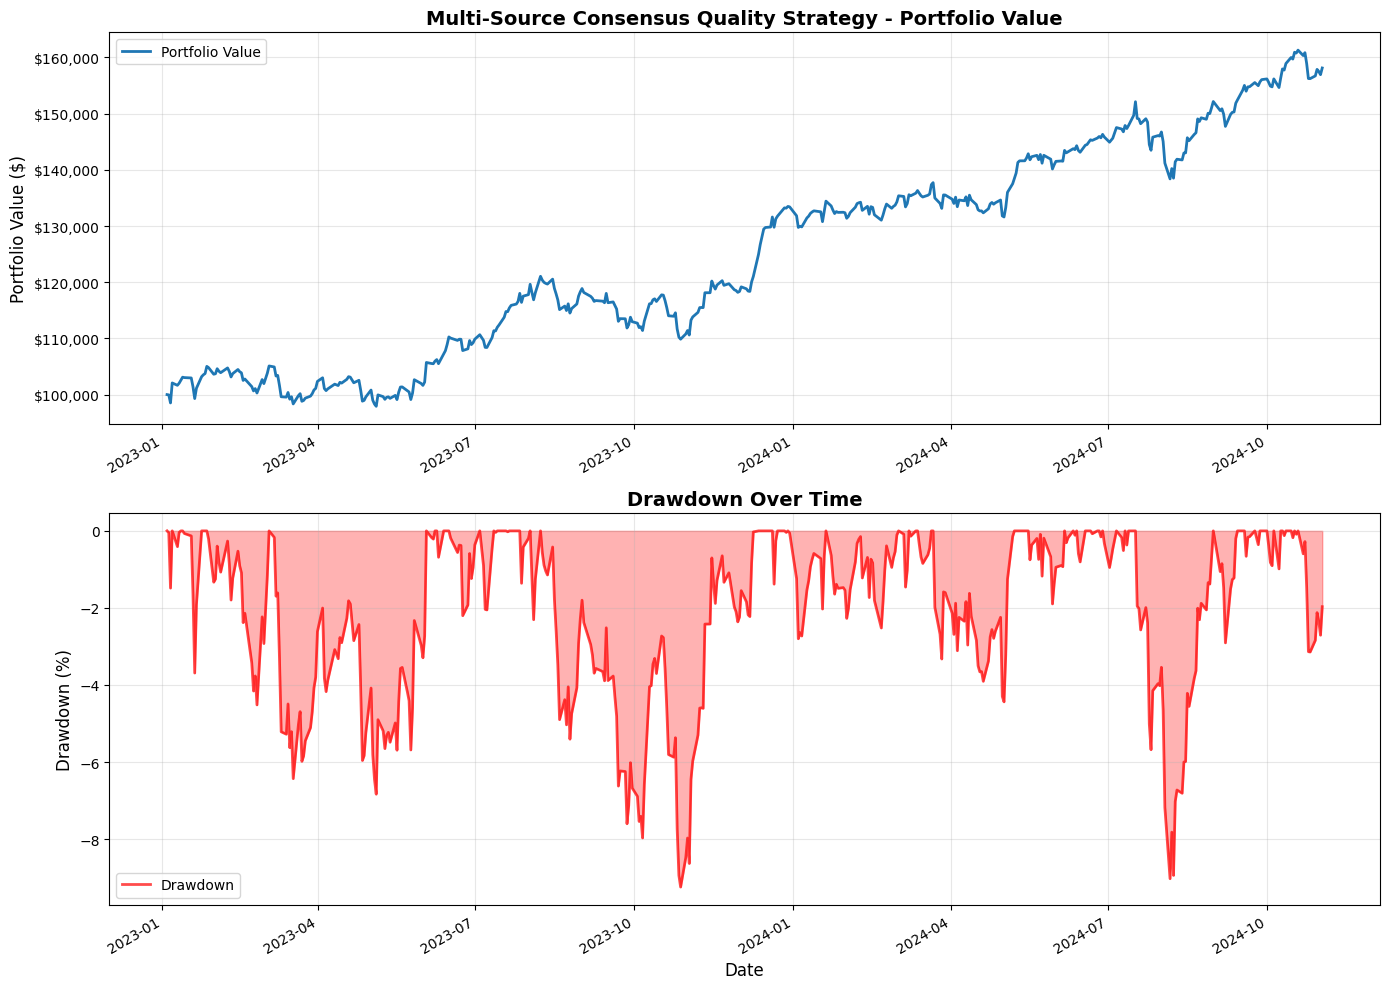

In [10]:
# Portfolio value and drawdown
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Portfolio value
results['portfolio_value'].plot(ax=ax1, label='Portfolio Value', linewidth=2)
ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
ax1.set_title('Multi-Source Consensus Quality Strategy - Portfolio Value', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Drawdown
(drawdown * 100).plot(ax=ax2, label='Drawdown', color='red', alpha=0.7, linewidth=2)
ax2.fill_between(drawdown.index, 0, drawdown * 100, color='red', alpha=0.3)
ax2.set_ylabel('Drawdown (%)', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_title('Drawdown Over Time', fontsize=14, fontweight='bold')
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Prepare Data for Pyfolio Analysis

In [11]:
# Import pyfolio
try:
    import pyfolio as pf
    PYFOLIO_AVAILABLE = True
    print("✓ Pyfolio imported successfully")
except ImportError:
    PYFOLIO_AVAILABLE = False
    print("⚠️  Pyfolio not installed. Install with: pip install pyfolio-reloaded")
    print("   Skipping pyfolio analysis...")

✓ Pyfolio imported successfully


In [12]:
if PYFOLIO_AVAILABLE:
    # Extract returns (required)
    returns = results['returns']
    
    # Extract positions (optional but recommended)
    positions_data = []
    
    for date, row in results.iterrows():
        pos_dict = {}
        
        # Get cash
        if 'cash' in results.columns:
            pos_dict['cash'] = row['cash']
        
        # Get stock positions
        if row['positions']:
            for pos in row['positions']:
                sid = pos['sid']
                amount = pos['amount']
                last_sale_price = pos['last_sale_price']
                
                if hasattr(sid, 'symbol'):
                    symbol = sid.symbol
                    pos_dict[symbol] = amount * last_sale_price
        
        if pos_dict:
            positions_data.append((date, pos_dict))
    
    if positions_data:
        positions = pd.DataFrame([p[1] for p in positions_data],
                                index=[p[0] for p in positions_data])
        positions = positions.fillna(0)
    else:
        positions = None
    
    # Extract transactions (optional)
    transactions_list = []
    for date, row in results.iterrows():
        if row['transactions']:
            for txn in row['transactions']:
                sid = txn['sid']
                symbol = sid.symbol if hasattr(sid, 'symbol') else str(sid)
                
                transactions_list.append({
                    'symbol': symbol,
                    'amount': txn['amount'],
                    'price': txn['price'],
                    'value': txn['amount'] * txn['price'],
                })
    
    if transactions_list:
        transactions = pd.DataFrame(transactions_list,
                                   index=[date for date, row in results.iterrows()
                                         if row['transactions'] for _ in row['transactions']])
    else:
        transactions = None
    
    print("✓ Data prepared for pyfolio")
    print(f"  Returns: {len(returns)} days")
    if positions is not None:
        print(f"  Positions: {len(positions)} days, {len(positions.columns)} assets")
    print(f"  Transactions: {len(transactions) if transactions is not None else 0} trades")

✓ Data prepared for pyfolio
  Returns: 462 days
  Positions: 462 days, 18 assets
  Transactions: 363 trades


## Generate Pyfolio Tearsheet

This creates a comprehensive analysis including:
- Summary statistics
- Worst drawdown periods
- Rolling metrics (Sharpe, volatility)
- Monthly/yearly returns heatmap
- Return distribution plots
- Position analysis
- Transaction analysis

Start date,2023-01-03
End date,2024-11-01
Total months,22
,Backtest
Annual return,28.394%
Cumulative returns,58.124%
Annual volatility,14.694%
Sharpe ratio,1.77
Calmar ratio,3.07
Stability,0.95
Max drawdown,-9.245%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.25,2023-08-07,2023-10-27,2023-12-11,91
1,9.03,2024-07-16,2024-08-05,2024-08-30,34
2,6.83,2023-03-03,2023-05-04,2023-06-02,65
3,4.52,2023-01-26,2023-02-24,2023-03-03,27
4,4.44,2024-03-21,2024-05-01,2024-05-07,34


Stress Events,mean,min,max
Covid,0.10%,-2.68%,3.61%


Top 10 long positions of all time,max
BKNG,23.86%
AVGO,23.53%
QCOM,21.70%
UNP,21.66%
CAT,21.59%
META,21.14%
LMT,21.14%
AAPL,21.00%
ADP,20.99%
TJX,20.97%


Top 10 short positions of all time,max


Top 10 positions of all time,max
BKNG,23.86%
AVGO,23.53%
QCOM,21.70%
UNP,21.66%
CAT,21.59%
META,21.14%
LMT,21.14%
AAPL,21.00%
ADP,20.99%
TJX,20.97%


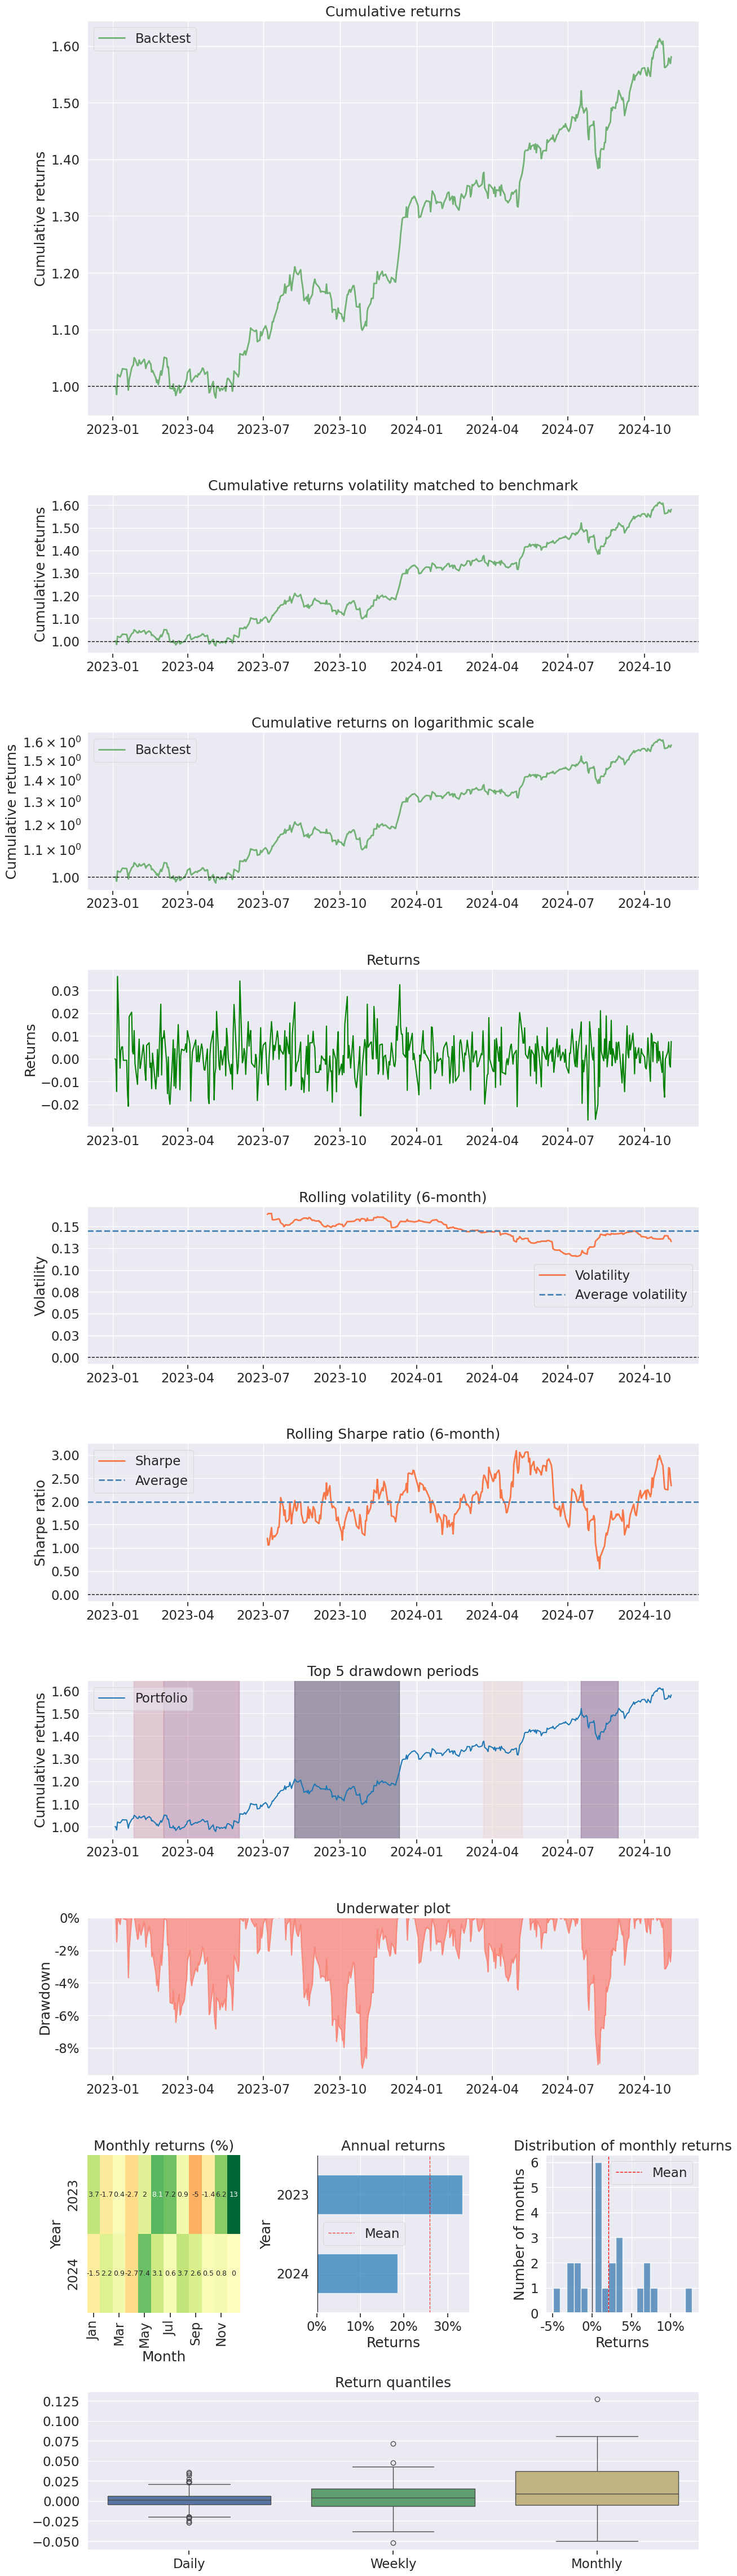

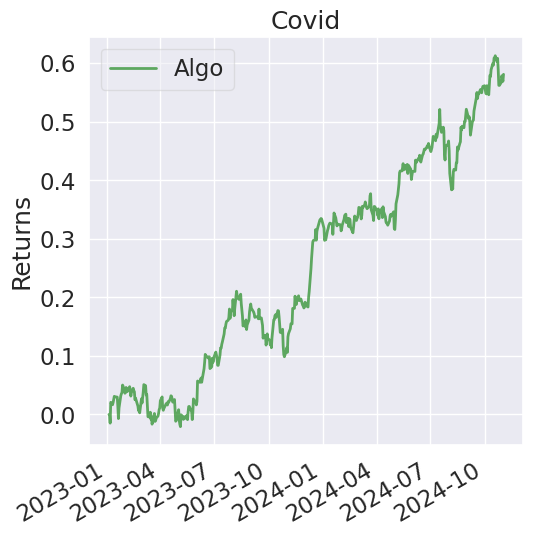

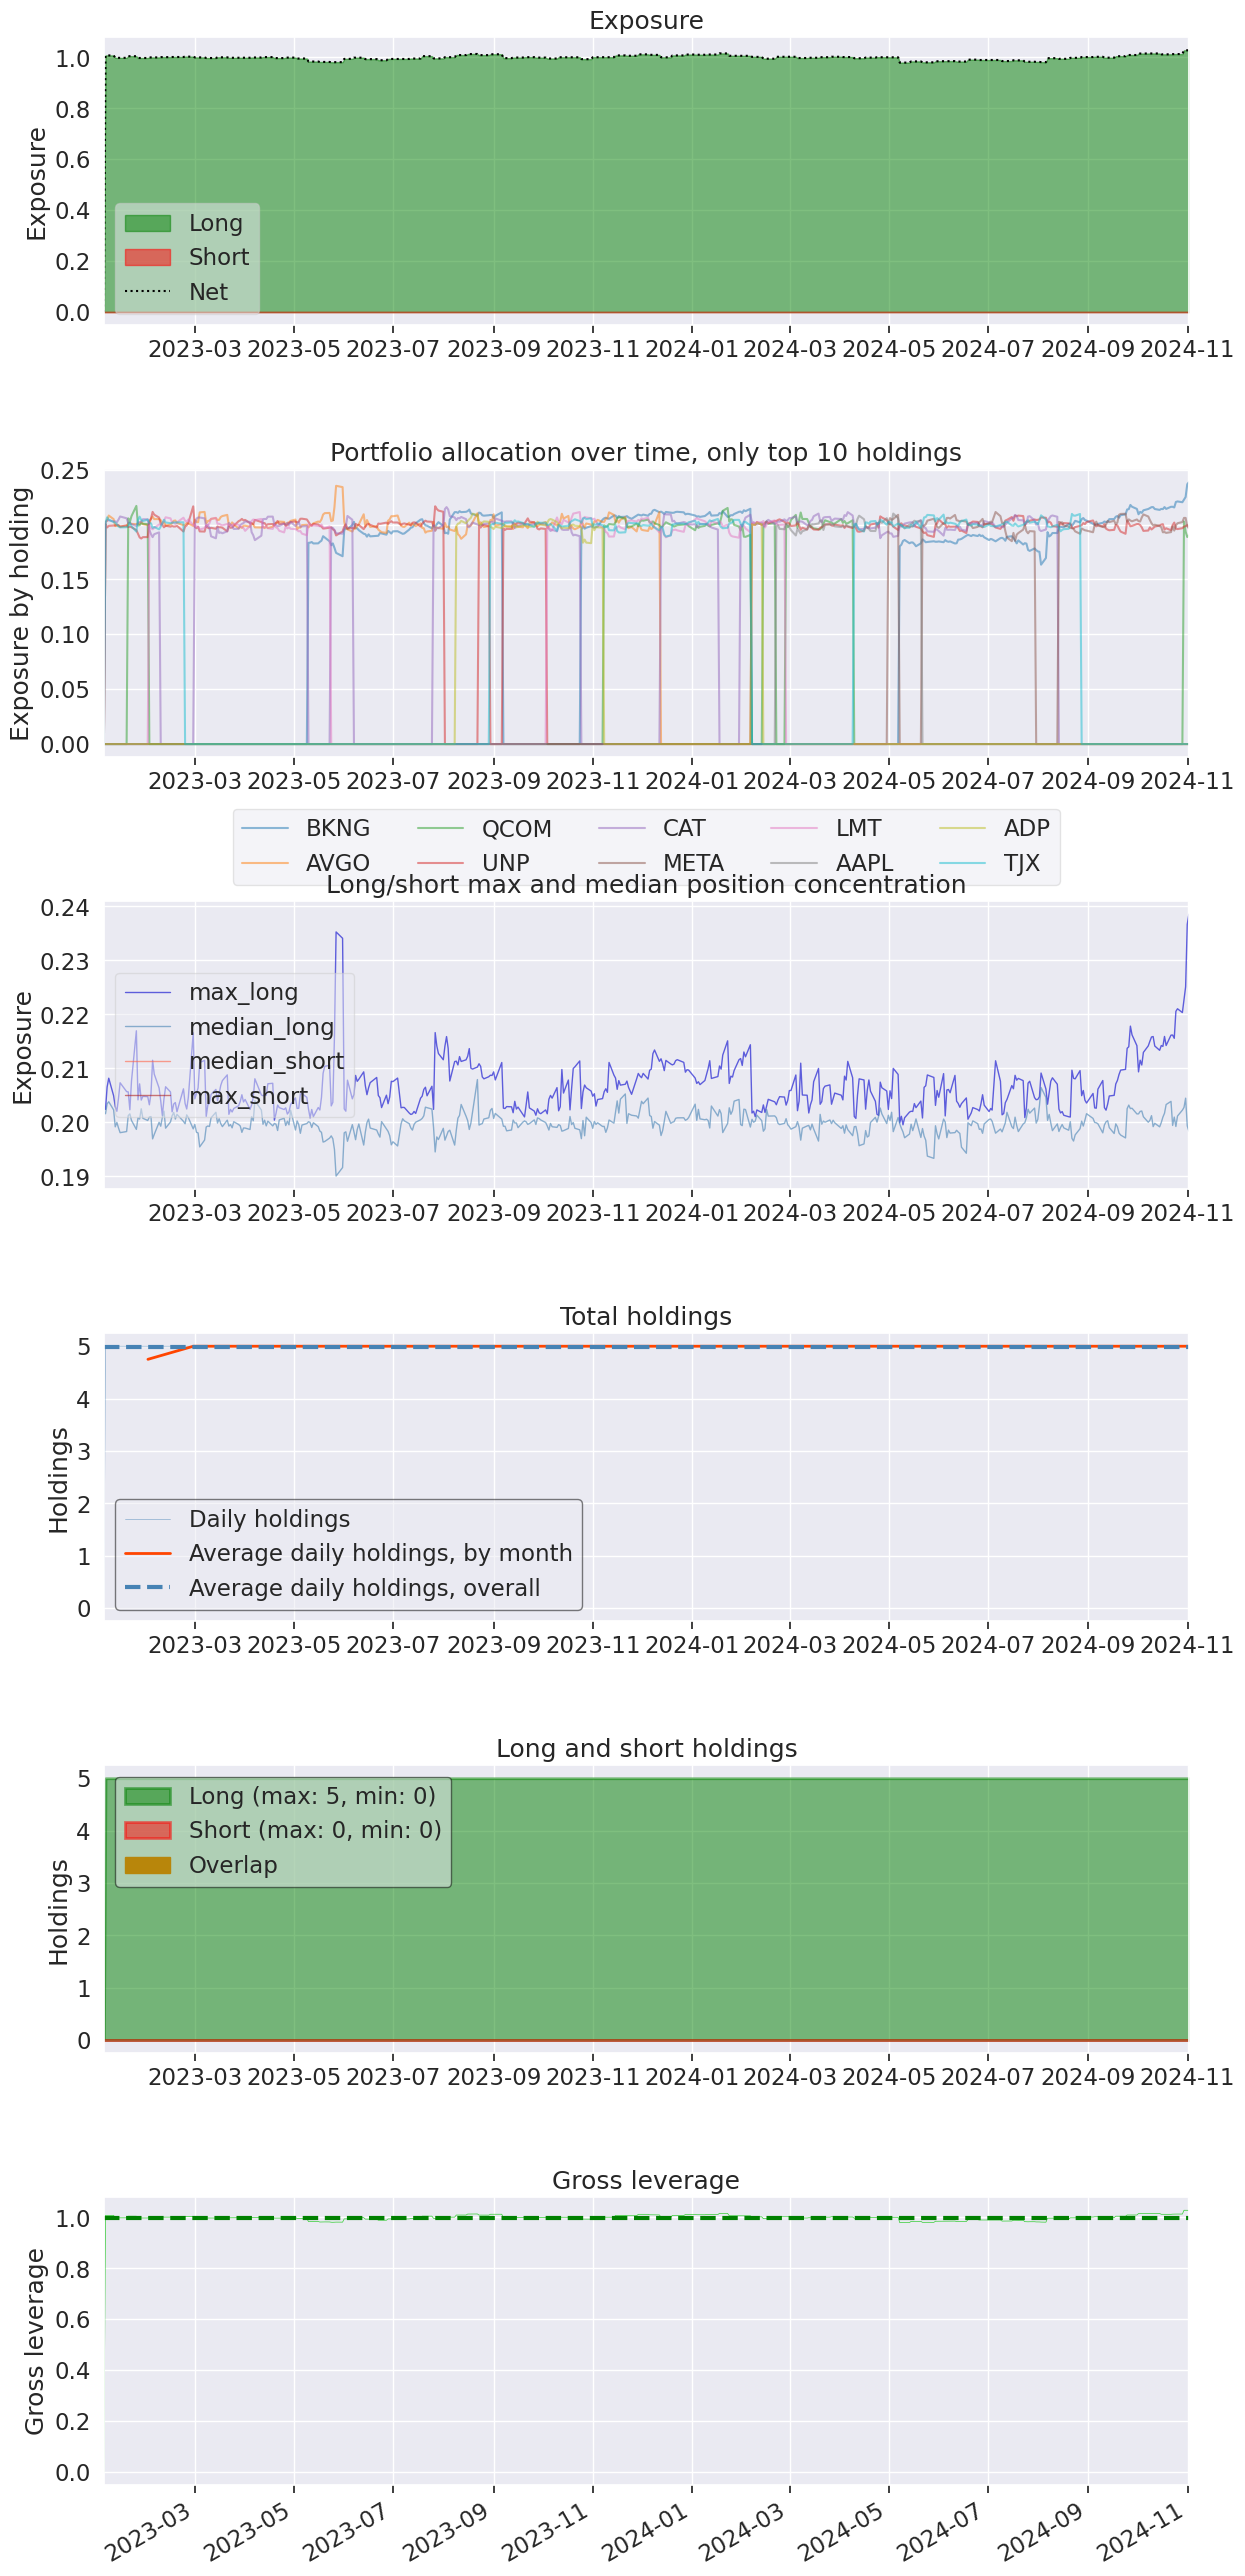

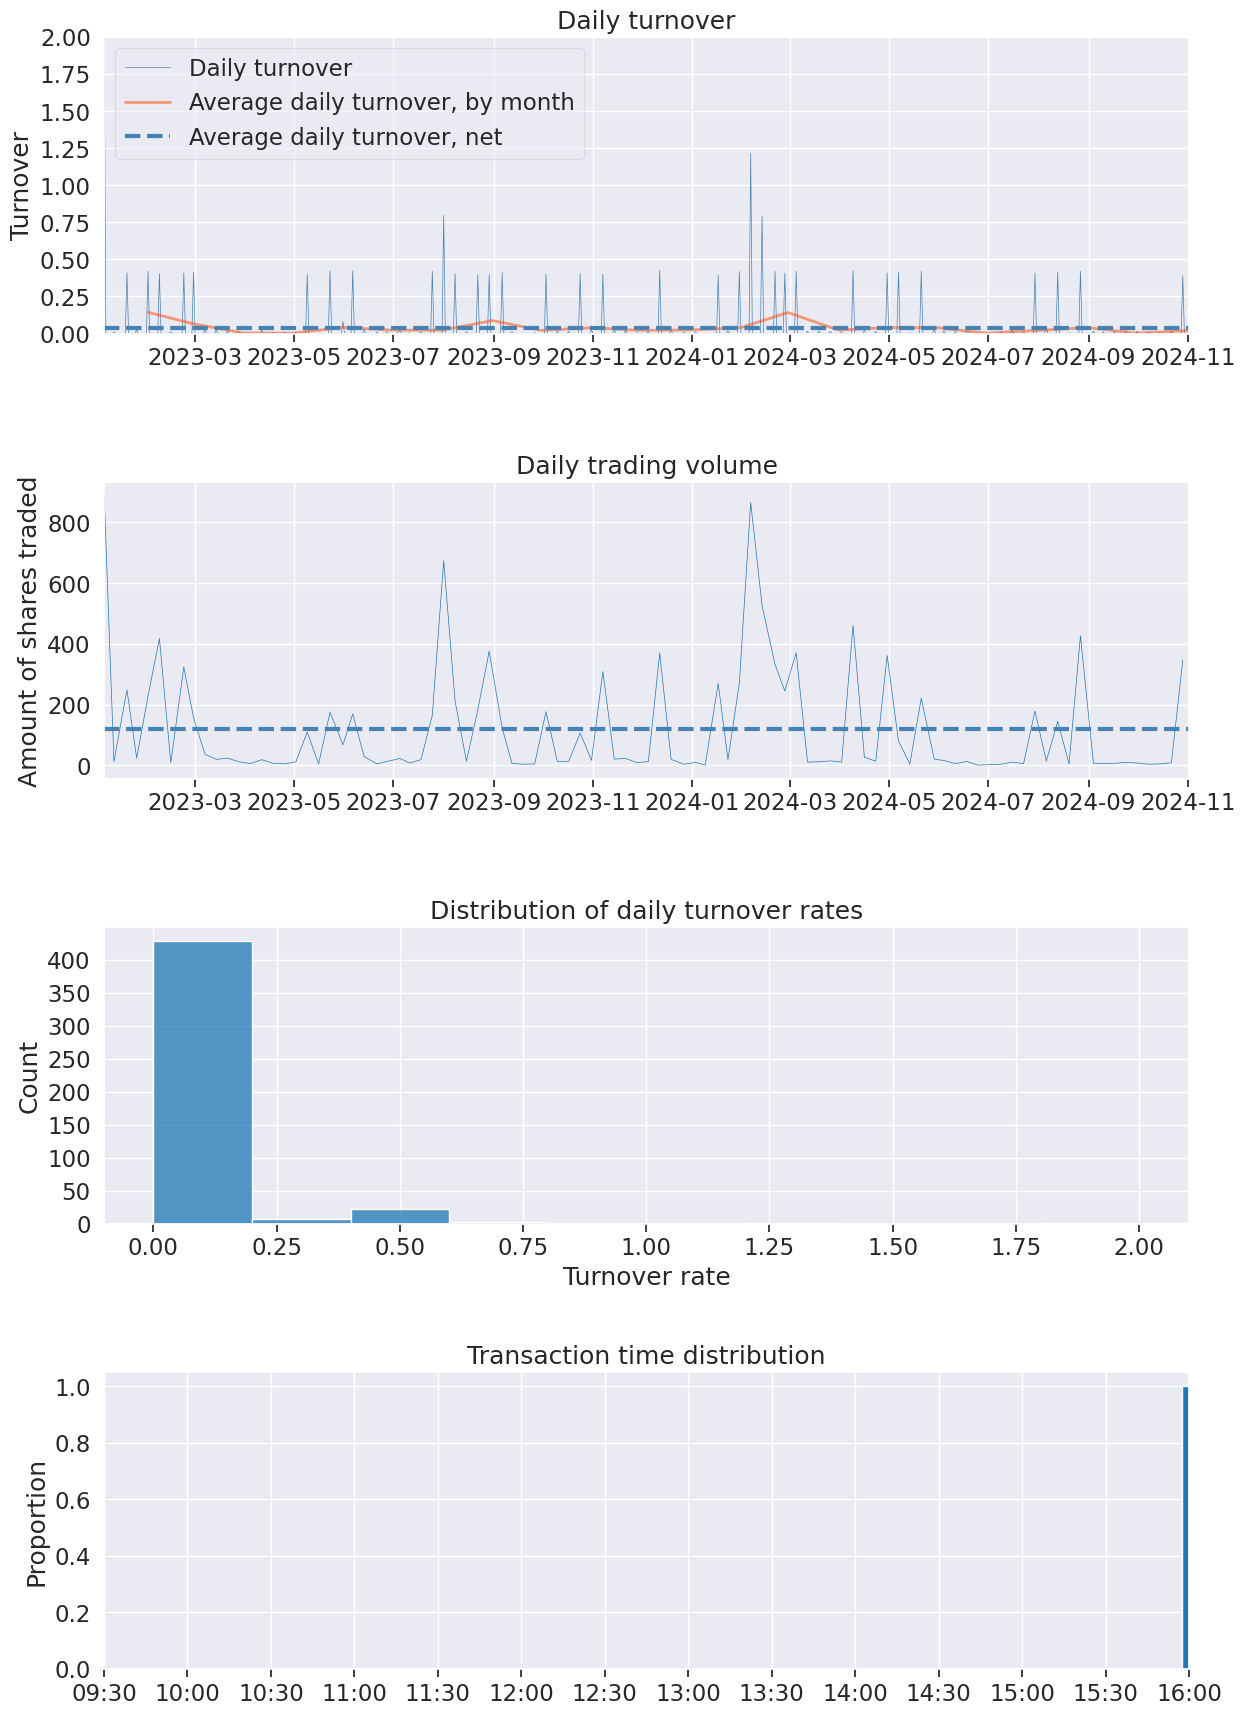

In [13]:
if PYFOLIO_AVAILABLE:
    # Create full tearsheet
    pf.create_full_tear_sheet(
        returns,
        positions=positions,
        transactions=transactions,
        live_start_date=None,
        round_trips=False,
        estimate_intraday=False,
    )
else:
    print("Pyfolio not available - skipping tearsheet generation")

## Additional Pyfolio Metrics

In [14]:
if PYFOLIO_AVAILABLE:
    # Calculate detailed metrics
    annual_return = pf.timeseries.annual_return(returns)
    sharpe_ratio = pf.timeseries.sharpe_ratio(returns)
    max_drawdown = pf.timeseries.max_drawdown(returns)
    sortino_ratio = pf.timeseries.sortino_ratio(returns)
    calmar_ratio = pf.timeseries.calmar_ratio(returns)
    volatility = pf.timeseries.annual_volatility(returns)
    
    print("\n" + "="*60)
    print("DETAILED PYFOLIO METRICS")
    print("="*60)
    print(f"Annual Return: {annual_return*100:.2f}%")
    print(f"Annual Volatility: {volatility*100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Sortino Ratio: {sortino_ratio:.2f}")
    print(f"Calmar Ratio: {calmar_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown*100:.2f}%")
    print("="*60)
    
    # Cumulative returns
    cum_returns = pf.timeseries.cum_returns(returns)
    total_return = cum_returns.iloc[-1]
    print(f"\nTotal Return: {total_return*100:.2f}%")


DETAILED PYFOLIO METRICS
Annual Return: 28.39%
Annual Volatility: 14.69%
Sharpe Ratio: 1.77
Sortino Ratio: 2.75
Calmar Ratio: 3.07
Max Drawdown: -9.25%

Total Return: 58.12%


## Export Results

In [15]:
# Uncomment to save results
# results.to_csv('multi_source_backtest_results.csv')
# returns.to_csv('multi_source_returns.csv')
# if positions is not None:
#     positions.to_csv('multi_source_positions.csv')
# if transactions is not None:
#     transactions.to_csv('multi_source_transactions.csv')

print("To save results, uncomment the lines above.")

To save results, uncomment the lines above.


## Summary

### What We Accomplished

1. **Multi-Source Integration:** Successfully combined Sharadar and LSEG fundamentals in one pipeline
2. **Simple Setup:** Used centralized `multi_source` module for clean imports
3. **Auto Loader:** One-line setup with `ms.setup_auto_loader()`
4. **FlightLog Monitoring:** Real-time log streaming during backtest
5. **Comprehensive Analysis:** Pyfolio tearsheet with detailed metrics

### Key Features

- **Consensus Scoring:** Higher confidence when multiple sources agree
- **Quality Filters:** ROE > 15%, FCF > 0, PE < 30, PEG < 2.5
- **Weekly Rebalancing:** Systematic position updates
- **Equal Weighting:** Simple, transparent allocation

### Next Steps

1. **Experiment with parameters:**
   - Universe size (50, 100, 200)
   - Selection size (3, 5, 10)
   - Quality thresholds
   - Rebalancing frequency

2. **Add more factors:**
   - Momentum
   - Value metrics
   - Technical indicators

3. **Compare strategies:**
   - Sharadar only
   - LSEG only
   - Consensus (both sources)

4. **Risk management:**
   - Position sizing
   - Stop losses
   - Volatility targeting

### Resources

- **Documentation:** `docs/MULTI_SOURCE_DATA.md`
- **Quick Reference:** `docs/MULTI_SOURCE_QUICKREF.md`
- **Examples:** `examples/multi_source_data/simple_multi_source_example.py`